# Random generate ece plot

In [ ]:

conf_bins = np.linspace(0,1,11) + 0.05
conf_bins = conf_bins[:-1]
conf_bins

acc_bins = np.add(conf_bins,np.random.uniform(-0.08,0.03,size=len(conf_bins)))
acc_bins

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

array([0.04635097, 0.14580206, 0.25697951, 0.317098  , 0.40893801,
       0.47067459, 0.57920795, 0.68893578, 0.87223338, 0.92746658])

In [ ]:
height = np.random.uniform(0,1,len(conf_bins))
softmax = lambda a: np.exp(a)/np.sum(np.exp(a))
dist = softmax(height)

In [ ]:
res = pd.DataFrame({'bins':conf_bins - 0.05,'acc':acc_bins,'dist':dist,'bin_ces':acc_bins - conf_bins})
res

,bins,acc,dist,bin_ces
0,0.0,0.046351,0.110927,-0.003649
1,0.1,0.145802,0.084741,-0.004198
2,0.2,0.256980,0.067138,0.006980
3,0.3,0.317098,0.122178,-0.032902
4,0.4,0.408938,0.135459,-0.041062
5,0.5,0.470675,0.100548,-0.079325
6,0.6,0.579208,0.082460,-0.070792
7,0.7,0.688936,0.062519,-0.061064
8,0.8,0.872233,0.082937,0.022233
9,0.9,0.927467,0.151092,-0.022533


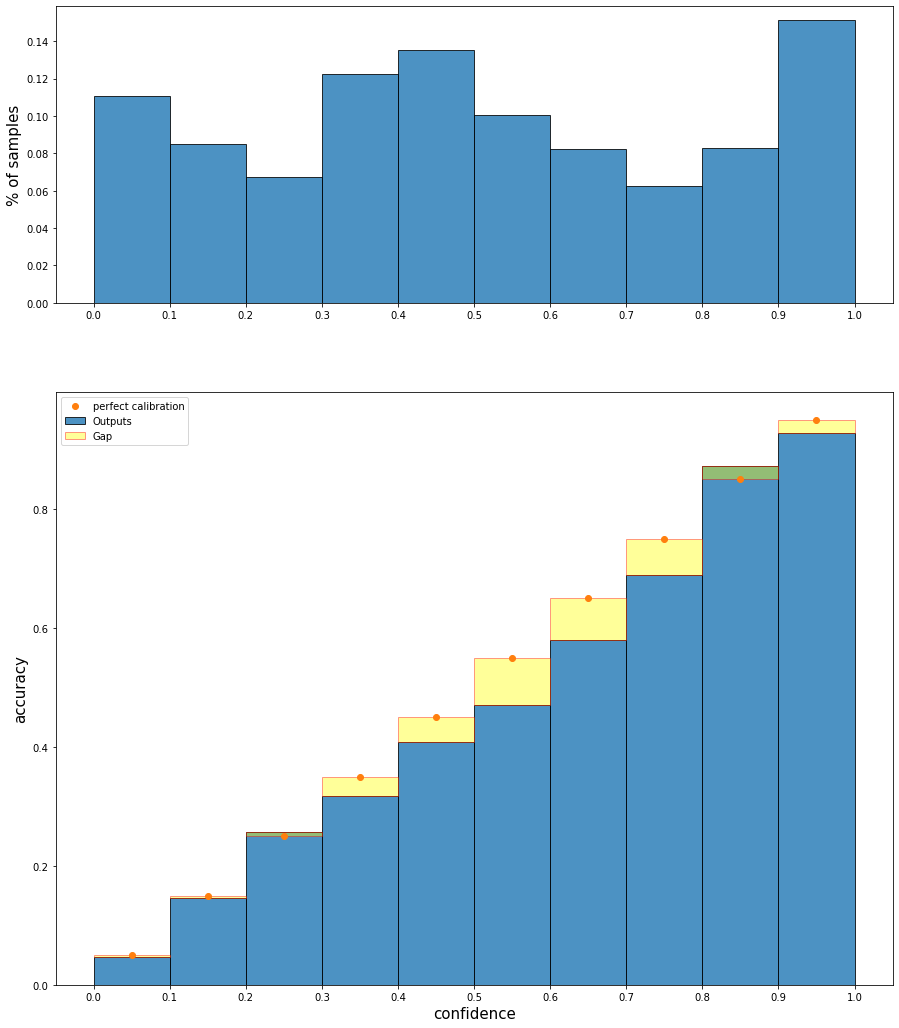

In [88]:
fig, axs = plt.subplots(2,1,gridspec_kw={'height_ratios': [2,4]},figsize=(15,18))

axs[0].bar(x=res['bins'],height=res['dist'],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[0].set_xticks(ticks = res['bins'].tolist() + [1.0] );
#axs[0].set_xlabel('confidence',fontsize=10);
axs[0].set_ylabel('% of samples',fontsize=15);
#plt.tight_layout();
#axs[0,0].set_title(f'Example of a Re | ECE = {round(res["ece"],3)}',fontsize=15)

bottom = [acc if acc < (res['bins'][i] + 0.05) else res['bins'][i] + 0.05 for i,acc in enumerate(res['acc'])]


axs[1].bar(x=res['bins'],height=res['acc'],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[1].bar(x=res['bins'],height=res['bin_ces'].abs(),width=0.1,color='yellow',edgecolor='red',bottom=bottom,alpha=0.4,align='edge',label='Gap')
axs[1].scatter(res['bins'] + 0.05,res['bins'] + 0.05,label='perfect calibration');
axs[1].set_xticks(ticks = res['bins'].tolist() + [1.0]);
#plt.title('Reliability Diagram');
axs[1].set_xlabel('confidence',fontsize=15);
axs[1].set_ylabel('accuracy',fontsize=15);
#plt.savefig('media/reliability_diagram_MLP_mimic.png');
#plt.tight_layout();
#plt.plot(x,x,'-.');
axs[1].legend();
plt.savefig('media/example_calibration_plot.png');

<BarContainer object of 10 artists>

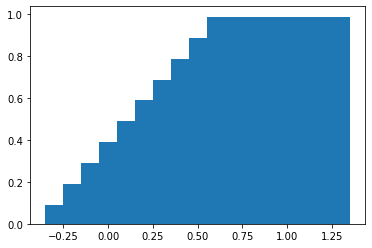

In [15]:
axs[0,0].bar(x=res['bins'][:-1],height=[e / sum(res['n_bins']) for e in res['n_bins']],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[0,0].set_xticks(ticks = res['bins']);
#axs[0].set_xlabel('confidence',fontsize=10);
axs[0,0].set_ylabel('% of samples',fontsize=15);
#plt.tight_layout();
axs[0,0].set_title(f'MLP model | ECE = {round(res["ece"],3)}',fontsize=15)

# Imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import ast

from rnn_utils import *
from mourga_variational.variational_rnn import RNN_MC
import random

import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SubsetRandomSampler
from torch.nn import Sigmoid
from sklearn.metrics import precision_recall_curve

from torchmetrics import Accuracy,Recall, Precision, F1Score, AUROC

from sklearn.model_selection import ParameterGrid, ParameterSampler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import recall_score,precision_score,f1_score
from scipy.stats import skew as compute_skew
from scipy.stats import kurtosis as compute_kurtosis

import numpy as np
import pandas as pd
import json

from tqdm.notebook import tqdm

from config import Settings; settings = Settings()

from ICDMappings import ICDMappings
icdmap = ICDMappings()

import wandb
import torchmetrics.functional as f

idx = pd.IndexSlice

# Reproducibility

In [3]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create dataset & dataloaders

## Whole history (MLP, baselines and LR)

In [92]:
dataset_folder = '/home/debian/Simao/master-thesis/data/model_ready_dataset/icare2021_diag_A301/dataset_added_new_targets.json'
ccs_universe = list(icdmap.icd9_3toccs.data.keys())
dataset_all = ICareDataset(dataset_folder,
                       ccs_universe,
                       input='history_cumulative',
                       target='target',
                       grouping='ccs',
                       opt_size=0.25
                      )

n_labels = input_size = dataset_all.grouping_data['ccs']['n_labels']

batch_size=32
train_dataloader_all = DataLoader(dataset_all,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_all.train_indices)
                           )
train_no_opt_dataloader_all = DataLoader(dataset_all,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_all.train_no_opt_indices)
                           )
opt_dataloader_all = DataLoader(dataset_all,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_all.opt_indices)
                           )
val_dataloader_all = DataLoader(dataset_all,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_all.val_indices)
                           )

test_dataloader_all = DataLoader(dataset_all,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_all.test_indices)
                           )

# Nº batches
len(train_dataloader_all)
len(val_dataloader_all)
len(test_dataloader_all)

n_labels = input_size = dataset.grouping_data['ccs']['n_labels']

processing each patient


  0%|          | 0/262811 [00:00<?, ?it/s]

5749

1232

1232

In [93]:
total_empty = 0
total = 0
for batch in tqdm(train_dataloader_all):
    total_empty += sum([len(adm) == 0 for pat in batch['target_original'] for adm in pat])
    total += sum([len(pat) for pat in batch['target_original']])
total_empty
total

  0%|          | 0/5749 [00:00<?, ?it/s]

290116

1270192

In [4]:
dataset_folder = '/home/debian/Simao/master-thesis/data/model_ready_dataset/icare2021_diag_A301/dataset_added_new_targets.json'
ccs_universe = list(icdmap.icd9_3toccs.data.keys())
dataset = ICareDataset(dataset_folder,
                       ccs_universe,
                       input='history_cumulative',
                       target='new_target',
                       grouping='ccs',
                       opt_size=0.25
                      )

n_labels = input_size = dataset.grouping_data['ccs']['n_labels']

processing each patient


  0%|          | 0/262811 [00:00<?, ?it/s]

In [5]:
batch_size=32
train_dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset.train_indices)
                           )
train_no_opt_dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset.train_no_opt_indices)
                           )
opt_dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset.opt_indices)
                           )
val_dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset.val_indices)
                           )

test_dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset.test_indices)
                           )

# Nº batches
len(train_dataloader)
len(val_dataloader)
len(test_dataloader)

n_labels = input_size = dataset.grouping_data['ccs']['n_labels']

5749

1232

1232

## admission only (RNN)

In [180]:
dataset_folder = '/home/debian/Simao/master-thesis/data/model_ready_dataset/icare2021_diag_A301/dataset_added_new_targets.json'
ccs_universe = list(icdmap.icd9_3toccs.data.keys())
dataset_rnn = ICareDataset(dataset_folder,
                           ccs_universe,
                           input='history',
                           target='target',
                           grouping='ccs',
                           opt_size=0.25
                          )
n_labels = input_size = dataset_rnn.grouping_data['ccs']['n_labels']

processing each patient


  0%|          | 0/262811 [00:00<?, ?it/s]

Dataloaders

In [181]:
batch_size=32
train_dataloader_rnn = DataLoader(dataset_rnn,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_rnn.train_indices)
                           )
train_no_opt_dataloader_rnn = DataLoader(dataset_rnn,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_rnn.train_no_opt_indices)
                           )
opt_dataloader_rnn = DataLoader(dataset_rnn,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_rnn.opt_indices)
                           )
val_dataloader_rnn = DataLoader(dataset_rnn,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_rnn.val_indices)
                           )

test_dataloader_rnn = DataLoader(dataset_rnn,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_rnn.test_indices)
                           )


# Nº batches
len(train_dataloader_rnn)
len(val_dataloader_rnn)
len(test_dataloader_rnn)

5749

1232

1232

# EDA on MIMIC-III

## Number of patients in this dataset

In [ ]:
len(dataset)

## Distribution of sequence length size

In [ ]:
lengths = []
for pat in tqdm(dataset):
    lengths.append(pat['length'])
res = pd.Series(lengths)

In [ ]:
top_10 = pd.concat([res[res!=1].value_counts().rename('Count'),res[res!=1].value_counts(normalize=True).rename('frac').round(2)],axis=1).head(10)
top_10.Count.plot.bar();
plt.title('Distribution of sequence size in the whole dataset');
plt.xlabel('sequence size');
plt.ylabel('Number of datapoints');
plt.savefig('media/dist_seq_size_dataset.png');

## Prevalence of each diagnostic

In [ ]:
a = pd.Series(compute_prevalence_dataloader(val_dataloader,how='each')).sort_values(ascending=False).to_frame('prevalence').rename_axis(index='int2code')
a.head(3)

In [ ]:
a['ccs'] = [dataset.grouping_data['ccs']['int2code'][x] for x in a.index]
a['desc'] = icdmap.lookup('ccstodescription',a['ccs'])
a

In [ ]:
compute_prevalence_dataloader(train_dataloader,how='all')

now in terms of ratio

In [ ]:
ratio = 1/compute_prevalence_dataloader(train_dataloader,how='all')
ratio

## Size of each timestep

In [ ]:
all_timesteps = list()
for pat in tqdm(dataset):
    all_timesteps.extend([len(ts) for ts in pat['history_original']])

In [ ]:
pd.Series(all_timesteps).describe().round(2)

## Target size

In [ ]:
pat_per_datapoint = list()
diags_per_datapoint = list()
for pat in tqdm(dataset):
    for datapoint in pat['new_target_original']:
        pat_per_datapoint.append(pat['pid'])
        diags_per_datapoint.append(len(datapoint))


df = pd.DataFrame(data=[pat_per_datapoint,diags_per_datapoint],
                  index=['pat','n']
                 ).T

res = df.n.value_counts().to_frame('n')
res.loc[:,'percentage'] = (res['n'] / res['n'].sum()).round(2)
res = res.rename_axis(index='target size distribution')

res.head(8)

In [ ]:
target_sizes = list()
for pat in tqdm(dataset):
    target_sizes.extend([len(ts) for ts in pat['target_original']])

In [ ]:
pd.concat([pd.Series(all_timesteps).describe().round(2).rename('timestep size'),
           pd.Series(target_sizes).describe().round(2).rename('target size')
          ],axis=1).iloc[1:].astype(str)

In [ ]:
print(pd.concat([pd.Series(all_timesteps).describe().round(2).rename('timestep size'),
           pd.Series(target_sizes).describe().round(2).rename('target size')
          ],axis=1).iloc[1:].astype(str).style.to_latex())

need to title this

### Datapoints per patient

In [ ]:
pat_size = df.groupby('pat').size()
pat_size.describe().to_frame('Datapoints per patient')

In [ ]:
pd.Series(a.index.values).astype(int)

## ccs distribution

In [ ]:
all_diags = list()
for pat in dataset:
    for adm in pat['history_original']:
        all_diags.extend(adm)
    all_diags.extend(pat['target_original'][-1])

In [ ]:
a['%'].plot.box()
print(a.describe().drop(['count']).round(3).to_latex())

In [ ]:
a.iloc[5]['ccs description']

In [ ]:
diag_dist_count = pd.Series(all_diags,name='count').value_counts(normalize=False)
diag_dist_freq = pd.Series(all_diags,name='%').value_counts(normalize=True) * 100
a = pd.concat([diag_dist_count,diag_dist_freq],axis=1).sort_values('count',ascending=False).rename_axis(index='ccs')
a.loc[:,'ccs description'] = icdmap.lookup('ccstodescription',pd.Series(a.index.values).astype(int)).values
a.index = a.index.astype(int)
a = a.round(1)
#a['rank'] = 
print(a.head(10).to_latex())

# MLP

## Create metrics

In [ ]:
topk = 10
metrics_factory = {'avgprec':{'func':AveragePrecision,
                      'kwargs':dict(num_classes=n_labels,average=None,multiclass=False),
                      'extra_pooling':['weighted']
                     },
                   f'recall@{topk}':{'func':Recall,
                                'kwargs':dict(top_k=topk,average='samples',num_classes=n_labels),
                                'extra_pooling':[]
                               },
                   f'precision@{topk}':{'func':Precision,
                                'kwargs':dict(top_k=topk,average='samples',num_classes=n_labels),
                                'extra_pooling':[]
                               }
          }

selectors = [MaskTimesteps('all')]

metrics = MetricsV2(metrics_factory,selectors)

## Train the model on small batch

In [ ]:
size = 16
overfit_batch = create_random_batch(size=size,dataset=dataset,collate_fn=ICareCOLLATE(input,target))

In [ ]:
epochs = 100

epoch_losses = list()

model = MLP(input_size=input_size,
            hidden_size=100,
            n_labels=n_labels,
            non_linear='relu')

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

metrics_every = 10
for epoch in tqdm(range(epochs)):
    epoch_losses.append(train_model_batch(model,overfit_batch,criterion,optimizer))
            
ths = {i:0.5 for i in range(n_labels)} #baseline thresholds

plt.plot(epoch_losses[-10:]);
plt.title('loss of last epochs');

metrics.update_metrics_batch(model,overfit_batch,ths)
res = metrics.compute_metrics()

In [ ]:
res['recall@30']

Yayy we are able to overfit! means the learning is working wellcompute_metrics

## Train the model on dataloader

In [ ]:
epochs = 10
n_labels = input_size = dataset.grouping_data['ccs']['n_labels']

epoch_losses = list()

metrics = MetricsV2(metrics_factory,selectors)

model = MLP(input_size=input_size,
            hidden_size=100,
            n_labels=n_labels,
            non_linear='relu')

optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

ths = {i:0.5 for i in range(n_labels)}

metrics_every = 1_000_000
epoch_losses.append(compute_loss_dataloader(model,train_dataloader,criterion))
for epoch in tqdm(range(epochs)):
    epoch_losses.append(train_model_dataloader(model,train_dataloader,criterion,optimizer))
    
metrics.update_metrics_dataloader(model,train_dataloader,ths)
train_m = metrics.compute_metrics()
metrics.reset_metrics()
metrics.update_metrics_dataloader(model,val_dataloader,ths)
val_m = metrics.compute_metrics()

plt.plot(epoch_losses)
plt.title('Loss')

In [ ]:
train_m['recall@30']

## Wandb several models

### reproducibility

In [135]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### metrics

In [136]:
metrics_factory = {'avgprec':{'func':AveragePrecision,
                      'kwargs':dict(num_classes=n_labels,average=None,multiclass=False),
                      'extra_pooling':['weighted']
                     }
          }

selectors = [MaskTimesteps('all')]

metrics = MetricsV2(metrics_factory,selectors)

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### Grid search

In [137]:
Uparams = dict(hidden_sizes=[[50],[150],[250],[100,100]],
               lr=[3e-4,6e-4,2e-3],
               batch_size=[8,16,32],
               weight_decay= [0,1e-5]
              )

params = list(ParameterGrid(Uparams))

# random grid search up to <search_space> iterations
search_space = 20
import random
random.shuffle(params)
size = len(params)
params = params[:search_space]

### pipeline

In [9]:
assert 1 == 2
epochs = 8

ths = {i:0.5 for i in range(n_labels)}

for param_set in tqdm(params):
    
    config = {
          "batch_size": param_set['batch_size'],
          "epochs": epochs,
          "input":'ccs',
          "output":'ccs',
          "manual_seed":seed,
          "hidden_size":param_set['hidden_sizes'][0],
          "num_layers":len(param_set['hidden_sizes']),
          "name":'MLP',
          "target": "new-only",
          "lr":param_set["lr"],
        "weight_decay": param_set['weight_decay']
        }

    wandb.init(project="icare-benchmark", entity="snovaisg",config=config)
    
    model = MLP(input_size=input_size,
                hidden_sizes=param_set['hidden_sizes'],
                n_labels=n_labels
                )

    optimizer = torch.optim.Adam(model.parameters(), lr=param_set['lr'],weight_decay=param_set['weight_decay'])
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    ths = {i:0.5 for i in range(n_labels)}
    
    train_dataloader = DataLoader(dataset,
                            batch_size=param_set['batch_size'],
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset.train_indices)
                           )

    for epoch in tqdm(range(epochs)):
        epoch_loss = train_model_dataloader(model,train_dataloader,criterion,optimizer)
        log = {'loss':epoch_loss}
        wandb.log(log)
    
    #metrics.reset_metrics()
    #metrics.update_metrics_dataloader(model,val_dataloader,ths)
    #val_m = metrics.compute_metrics()
    
    #val_avgprec = val_m['avgprec']['all']['weighted']
    val_loss_all = compute_loss_dataloader(model,val_dataloader,criterion)
    
    log = {'val_loss':val_loss_all}#,'val_avgprec':val_avgprec}
    wandb.log(log)

AssertionError: 

## Train best wandb model

### Choose Metrics

In [175]:
topk = 10
metrics_factory = {'avgprec':{'func':AveragePrecision,
                      'kwargs':dict(num_classes=n_labels,average=None,multiclass=False),
                      'extra_pooling':['weighted']
                     },
                   #f'recall@{topk}':{'func':Recall,
                   #             'kwargs':dict(top_k=topk,average='samples',num_classes=n_labels),
                   #             'extra_pooling':[]
                   #            },
                   #f'precision@{topk}':{'func':Precision,
                   #             'kwargs':dict(top_k=topk,average='samples',num_classes=n_labels),
                   #             'extra_pooling':[]
                   #            },
          }

selectors = [MaskTimesteps('all'),MaskTimesteps('below',2),MaskTimesteps('above',5)]

metrics = MetricsV2(metrics_factory,selectors)

### Parameters

In [173]:
lr = 6e-4
hidden_sizes = [50]
weight_decay = 0
epochs = 8
batch_size = 16

### Train Model

In [174]:
mlp_model = MLP(input_size=input_size,
            hidden_sizes=hidden_sizes,
            n_labels=n_labels
           )

optimizer = torch.optim.Adam(mlp_model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

ths = {i:0.5 for i in range(n_labels)}

train_dataloader_all = DataLoader(dataset_all,
                        batch_size=batch_size,
                        collate_fn=ICareCOLLATE(),
                        sampler=SubsetRandomSampler(dataset_all.train_indices)
                       )

# train model
for epoch in tqdm(range(epochs)):
    train_model_dataloader(mlp_model,train_dataloader_all,criterion,optimizer)

  0%|          | 0/8 [00:00<?, ?it/s]

Starting to train each batch


  0%|          | 0/11498 [00:00<?, ?it/s]

0.03902920593277066

Starting to train each batch


  0%|          | 0/11498 [00:00<?, ?it/s]

0.02650959664423736

Starting to train each batch


  0%|          | 0/11498 [00:00<?, ?it/s]

0.025841314059753956

Starting to train each batch


  0%|          | 0/11498 [00:00<?, ?it/s]

0.025604095693987403

Starting to train each batch


  0%|          | 0/11498 [00:00<?, ?it/s]

0.02546984696375058

Starting to train each batch


  0%|          | 0/11498 [00:00<?, ?it/s]

0.02542478720080655

Starting to train each batch


  0%|          | 0/11498 [00:00<?, ?it/s]

0.025309747756656616

Starting to train each batch


  0%|          | 0/11498 [00:00<?, ?it/s]

0.025274292427698495

### Show metrics

In [176]:
metrics = MetricsV2(metrics_factory,selectors)
#metrics.update_metrics_dataloader(mlp_model,train_dataloader,ths)
#train_m = metrics.compute_metrics()
metrics.reset_metrics()
metrics.update_metrics_dataloader(mlp_model,val_dataloader_all,{diag:0.5 for diag in range(n_labels)})
val_m = metrics.compute_metrics()

#metrics.reset_metrics()
#metrics.update_metrics_dataloader(mlp_model,test_dataloader,ths)
#test_m = metrics.compute_metrics()

Starting to iterate dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

In [187]:
n_labels

283

In [177]:
val_m['avgprec']['all']['weighted']
val_m['avgprec']['below_2']['weighted']
val_m['avgprec']['above_5']['weighted']

0.22741107642650604

0.18752141296863556

0.24014171957969666

In [38]:
val_m['avgprec']['all']['weighted']
val_m['recall@10']['all']['original']
val_m['precision@10']['all']['original']

0.05789966881275177

tensor(0.2398)

tensor(0.0471)

# RNN

## Choose metrics

In [139]:
metrics_factory = {'avgprec':{'func':AveragePrecision,
                      'kwargs':dict(num_classes=n_labels,average=None,multiclass=False),
                      'extra_pooling':['weighted']
                     }
          }

selectors = [MaskTimesteps('all')]

metrics = MetricsV2(metrics_factory,selectors)

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


## Grid Search

In [140]:
Uparams = dict(hidden_size=[50,150,250],
               lr=[3e-4,6e-4,2e-3],
               batch_size=[8,16,32],
               weight_decay=[0,1e-5],
               model_type=['rnn','gru','lstm']
              )

params = list(ParameterGrid(Uparams))

# random grid search up to <search_space> iterations
search_space = 20
import random
random.shuffle(params)
size = len(params)
params = params[:search_space]

## Pipeline

In [10]:
assert 1 == 2
epochs = 8

ths = {i:0.5 for i in range(n_labels)}

for param_set in tqdm(params):
    
    config = {
          "batch_size": param_set['batch_size'],
          "epochs": epochs,
          "input":'ccs',
          "output":'ccs',
          "manual_seed":seed,
          "hidden_size":param_set['hidden_size'],
          "num_layers":1,
          "name":'RNN',
          "target":"new-only",
          "type":param_set['model_type'],
          "lr":param_set["lr"],
        "weight_decay": param_set['weight_decay']
        }

    wandb.init(project="icare-benchmark", entity="snovaisg",config=config)
    
    model = RNN(input_size=input_size,
                hidden_size=param_set['hidden_size'],
                num_layers=1,
                n_labels=n_labels,
                model=param_set['model_type']
                )

    optimizer = torch.optim.Adam(model.parameters(), lr=param_set['lr'],weight_decay=param_set['weight_decay'])
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    ths = {i:0.5 for i in range(n_labels)}
    
    train_dataloader_rnn = DataLoader(dataset_rnn,
                            batch_size=param_set['batch_size'],
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_rnn.train_indices)
                           )

    for epoch in tqdm(range(epochs)):
        epoch_loss = train_model_dataloader(model,train_dataloader_rnn,criterion,optimizer)
        log = {'loss':epoch_loss}
        wandb.log(log)

    #metrics.reset_metrics()
    #metrics.update_metrics_dataloader(model,val_dataloader_rnn,ths)
    #val_m = metrics.compute_metrics()
    

    #val_avgprec = val_m['avgprec']['last']['weighted']    
    val_loss_all = compute_loss_dataloader(model,val_dataloader_rnn,criterion)
    
    log = {'val_loss':val_loss_all}#,'val_avgprec':val_avgprec}
    wandb.log(log)

AssertionError: 

## Train best wandb model

### Choose Metrics

In [182]:
topk = 10
metrics_factory = {'avgprec':{'func':AveragePrecision,
                      'kwargs':dict(num_classes=n_labels,average=None,multiclass=False),
                      'extra_pooling':['weighted']
                     },
                  # f'recall@{topk}':{'func':Recall,
                  #              'kwargs':dict(top_k=topk,average='samples',num_classes=n_labels),
                  #              'extra_pooling':[]
                  #             },
                  # f'precision@{topk}':{'func':Precision,
                  #              'kwargs':dict(top_k=topk,average='samples',num_classes=n_labels),
                  #              'extra_pooling':[]
                  #             }
          }

selectors = [MaskTimesteps('all'),MaskTimesteps('below',k=2),MaskTimesteps('above',5)]

metrics = MetricsV2(metrics_factory,selectors)

### Parameters

In [183]:
lr = 6e-4
hidden_size = 50
weight_decay = 0
epochs = 8
batch_size = 32
rnn_model = 'gru'

### Train Model

In [184]:
rnn_model = RNN(input_size=input_size,
                hidden_size=hidden_size,
                num_layers=1,
                n_labels=n_labels,
                model=rnn_model
                )

optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

ths = {i:0.5 for i in range(n_labels)}

train_dataloader_rnn = DataLoader(dataset_rnn,
                        batch_size=batch_size,
                        collate_fn=ICareCOLLATE(),
                        sampler=SubsetRandomSampler(dataset_rnn.train_indices)
                       )

# train model
for epoch in tqdm(range(epochs)):
    train_model_dataloader(rnn_model,train_dataloader_rnn,criterion,optimizer)

  0%|          | 0/8 [00:00<?, ?it/s]

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.04693359825005219

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.03270397732346333

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.0291329110446254

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.027233066648351126

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.026510247576105053

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.026126717161377485

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.0259230112472922

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.025763415941438182

### Show metrics

In [185]:
metrics = MetricsV2(metrics_factory,selectors)
#metrics.update_metrics_dataloader(rnn_model,train_dataloader_rnn,ths)
#train_m = metrics.compute_metrics()
metrics.reset_metrics()
metrics.update_metrics_dataloader(rnn_model,val_dataloader_rnn,{diag:0.5 for diag in range(n_labels)})
val_m = metrics.compute_metrics()

#metrics.reset_metrics()
#metrics.update_metrics_dataloader(rnn_model,test_dataloader_rnn,ths)
#test_m = metrics.compute_metrics()

Starting to iterate dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

In [186]:
val_m['avgprec']['all']['weighted']
val_m['avgprec']['below_2']['weighted']
val_m['avgprec']['above_5']['weighted']

0.28512200713157654

0.19992050528526306

0.315367192029953

In [159]:
val_m['avgprec']['all']['weighted']
val_m[f'recall@{topk}']['all']['original']
val_m[f'precision@{topk}']['all']['original']

0.06223388388752937

tensor(0.2326)

tensor(0.0457)

# Diagnostic wise evaluation

In [157]:
a = pd.Series([e.item() for e in val_m['avgprec']['all']['original']],name='avg prec').sort_values(ascending=False).to_frame()
a = ccsify_dataframe(a,dataset,icdmap)
a.sort_values('avg prec',ascending=False).head(10)

,avg prec,description
CCS,,
195,0.379142,Other complications of birth; puerperium affec...
196,0.241244,Other pregnancy and delivery including normal
258,0.235828,Other screening for suspected conditions (not ...
188,0.171999,Fetopelvic disproportion; obstruction
670,0.170942,Miscellaneous mental health disorders
259,0.126076,Residual codes; unclassified
663,0.110222,Screening and history of mental health and sub...
254,0.100003,Rehabilitation care; fitting of prostheses; an...
183,0.060944,Hypertension complicating pregnancy; childbirt...


In [100]:
val_m['recall@10']['all']

{'original': tensor(0.2326)}

In [ ]:
a = pd.Series([e.item() for e in val_m['avgprec']['all']['original']],name='avg prec').sort_values(ascending=False).to_frame()
a = ccsify_dataframe(a,dataset,icdmap)
a.sort_values('avg prec',ascending=False).head(10)

In [90]:
paper_diags = [24,196,12,29 ,14 ,36 ,20 ,15 ,30 ,37 ]
print(a.loc[paper_diags,:].round(3).to_latex())

\begin{tabular}{lrl}
\toprule
{} &  avg prec &                                    description \\
CCS &           &                                                \\
\midrule
24  &     0.019 &                               Cancer of breast \\
196 &     0.241 &  Other pregnancy and delivery including normal \\
12  &     0.001 &                            Cancer of esophagus \\
29  &     0.014 &                             Cancer of prostate \\
14  &     0.004 &                                Cancer of colon \\
36  &     0.018 &                              Cancer of thyroid \\
20  &     0.005 &    Cancer; other respiratory and intrathoracic \\
15  &     0.009 &                      Cancer of rectum and anus \\
30  &     0.000 &                               Cancer of testis \\
37  &     0.001 &                              Hodgkin`s disease \\
\bottomrule
\end{tabular}



/tmp/ipykernel_21264/3562467035.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(a.loc[paper_diags,:].round(3).to_latex())


# Create table of benchmark

In [67]:
all_results = [] # final table

## metrics

In [68]:
topk = 10
metrics_factory = {'avgprec':{'func':AveragePrecision,
                      'kwargs':dict(num_classes=n_labels,average=None,multiclass=False),
                      'extra_pooling':['weighted']
                     },
                    f'recall@{topk}':{'func':Recall,
                                'kwargs':dict(top_k=topk,average='samples',num_classes=n_labels),
                                'extra_pooling':[]
                               },
                   f'precision@{topk}':{'func':Precision,
                                'kwargs':dict(top_k=topk,average='samples',num_classes=n_labels),
                                'extra_pooling':[]
                               }
          }

selectors = [MaskTimesteps('all')]

metrics = MetricsV2(metrics_factory,selectors)

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


## baseline frequent

In [70]:
models = [repeatPast(how='last_admission'),repeatPast(how='whole_history'),repeatPast(how='top@3'),repeatPast(how='top@10')]
names = [m.how for m in models]
ths = {e:0.5 for e in range(n_labels)}

for i,model in enumerate(tqdm(models)):
    metrics.update_metrics_dataloader(model,test_dataloader,ths)
    res = metrics.compute_metrics()
    a = pd.DataFrame(res).applymap(lambda x: x['original'].item() if 'weighted' not in x.keys() else x['weighted'])
    a.columns = pd.MultiIndex.from_product([[names[i]],a.columns])
    all_results.append(a)
    metrics.reset_metrics()

  0%|          | 0/4 [00:00<?, ?it/s]

Starting to iterate dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate dataloader to update metrics


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate dataloader to update metrics


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate dataloader to update metrics


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/1232 [00:00<?, ?it/s]

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [71]:
pd.concat(all_results,axis=1)

last_admission                        whole_history            \
           avgprec recall@10 precision@10       avgprec recall@10   
all       0.020603   0.02727     0.005282      0.020603   0.02737   

                     top@3                           top@10            \
    precision@10   avgprec recall@10 precision@10   avgprec recall@10   
all     0.005311  0.020603  0.037082     0.007376  0.020603   0.02737   

                  
    precision@10  
all     0.005311

## best MLP model

### reproducibility

In [72]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Parameters

In [58]:
# name: mimic-iii-benchmark -> rose-salad-21
epochs = 20
hidden_sizes=[250]
lr=3e-4
weight_decay=1e-5
batch_size = 8

### Train

In [ ]:
mlp_model = MLP(input_size=n_labels,
            hidden_sizes=hidden_sizes,
            n_labels=n_labels
           )

optimizer = torch.optim.Adam(mlp_model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

ths = {i:0.5 for i in range(n_labels)}

train_dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        collate_fn=ICareCOLLATE(),
                        sampler=SubsetRandomSampler(dataset.train_indices)
                       )

# train model
for epoch in tqdm(range(epochs)):
    train_model_dataloader(mlp_model,train_dataloader,criterion,optimizer)


### Evaluate

In [73]:
metrics.reset_metrics()
metrics.update_metrics_dataloader(mlp_model,test_dataloader,ths)
res = metrics.compute_metrics()

a = pd.DataFrame(res).applymap(lambda x: x['original'].item() if 'weighted' not in x.keys() else x['weighted'])
a.columns = pd.MultiIndex.from_product([['MLP'],a.columns])
all_results.append(a)

Starting to iterate dataloader to update metrics


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/1232 [00:00<?, ?it/s]

## Best RNN

### reproducibility

In [74]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Parameters

In [ ]:
batch_size = 16
epochs = 20
hidden_size = 150
lr = 0.002
weight_decay = 0.00001
model_type = 'gru'

### Train

In [ ]:
rnn_model = RNN(input_size=input_size,
                hidden_size=hidden_size,
                num_layers=1,
                n_labels=n_labels,
                model=model_type
                )

optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr,weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

ths = {i:0.5 for i in range(n_labels)}

train_dataloader_rnn = DataLoader(dataset_rnn,
                        batch_size=batch_size,
                        collate_fn=ICareCOLLATE(),
                        sampler=SubsetRandomSampler(dataset_rnn.train_indices)
                       )

for epoch in tqdm(range(epochs)):
    train_model_dataloader(rnn_model,train_dataloader_rnn,criterion,optimizer)

### Evaluate

In [75]:
metrics.reset_metrics()
metrics.update_metrics_dataloader(rnn_model,test_dataloader_rnn,ths)
res = metrics.compute_metrics()

a = pd.DataFrame(res).applymap(lambda x: x['original'].item() if 'weighted' not in x.keys() else x['weighted'])
a.columns = pd.MultiIndex.from_product([['GRU'],a.columns])
all_results.append(a)

Starting to iterate dataloader to update metrics


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/1232 [00:00<?, ?it/s]

### Logistic Regression

In [22]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x,ignore_sigmoid=False):
        #linear layers don't support packs
        x = pad_packed_sequence(x,batch_first=True)[0]
        outs = self.linear(x)
        if ignore_sigmoid:
            return outs
        return torch.sigmoid(outs)

In [23]:
lr_model = LogisticRegression(input_dim=n_labels,
                              output_dim=n_labels
                             )

optimizer = torch.optim.Adam(lr_model.parameters(), lr=1e-3, weight_decay=0)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

ths = {i:0.5 for i in range(n_labels)}

train_dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        collate_fn=ICareCOLLATE(),
                        sampler=SubsetRandomSampler(dataset.train_indices)
                       )

# train model
for epoch in tqdm(range(epochs)):
    train_model_dataloader(lr_model,train_dataloader,criterion,optimizer)

  0%|          | 0/8 [00:00<?, ?it/s]

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.10379172673950789

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.02387876440844633

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.020334742801316738

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.019464731335174696

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.01908462950018597

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.018855893785990275

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.01871607712895886

Starting to train each batch


  0%|          | 0/5749 [00:00<?, ?it/s]

0.018617922654817688

In [41]:
metrics = MetricsV2(metrics_factory,selectors)
#metrics.update_metrics_dataloader(rnn_model,train_dataloader_rnn,ths)
#train_m = metrics.compute_metrics()
metrics.reset_metrics()
metrics.update_metrics_dataloader(lr_model,val_dataloader_rnn,ths)
val_m = metrics.compute_metrics()

metrics.reset_metrics()
metrics.update_metrics_dataloader(lr_model,test_dataloader_rnn,ths)
test_m = metrics.compute_metrics()

Starting to iterate dataloader to update metrics


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

In [42]:
val_m['avgprec']['all']['weighted']
val_m[f'recall@{topk}']['all']['original']
val_m[f'precision@{topk}']['all']['original']

0.04324961081147194

tensor(0.2173)

tensor(0.0427)

In [76]:
metrics.reset_metrics()
metrics.update_metrics_dataloader(lr_model,test_dataloader,ths)
res = metrics.compute_metrics()

a = pd.DataFrame(res).applymap(lambda x: x['original'].item() if 'weighted' not in x.keys() else x['weighted'])
a.columns = pd.MultiIndex.from_product([['LR'],a.columns])
all_results.append(a)

Starting to iterate dataloader to update metrics


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/1232 [00:00<?, ?it/s]

## Show table

In [81]:
#pd.concat(all_results,axis=1).T
idx = pd.IndexSlice
res = pd.concat(all_results,axis=1).T.loc[idx[:,['avgprec','recall@10','precision@10']],'all'].unstack(level=-1).sort_values('recall@10',ascending=False).round(3)#.loc[idx[:,['recall@30','precision@30']],['last']]#.to_frame()
res['mode'] = ['Model'] * 3 + ['baseline'] * 4
res = res.reset_index().set_index(['mode','index']).rename_axis(index=[None,None])
res = res.sort_index().sort_values('recall@10',ascending=False)
res.loc[idx['baseline',:],:] = 0
res.sort_values('avgprec',ascending=False)
print(res.sort_values('avgprec',ascending=False).to_latex())


avgprec  precision@10  recall@10
Model    GRU               0.061         0.046      0.234
         LR                0.058         0.048      0.245
         MLP               0.057         0.047      0.242
baseline top@3             0.000         0.000      0.000
         last_admission    0.000         0.000      0.000
         top@10            0.000         0.000      0.000
         whole_history     0.000         0.000      0.000

\begin{tabular}{llrrr}
\toprule
         &               &  avgprec &  precision@10 &  recall@10 \\
\midrule
Model & GRU &    0.061 &         0.046 &      0.234 \\
         & LR &    0.058 &         0.048 &      0.245 \\
         & MLP &    0.057 &         0.047 &      0.242 \\
baseline & top@3 &    0.000 &         0.000 &      0.000 \\
         & last\_admission &    0.000 &         0.000 &      0.000 \\
         & top@10 &    0.000 &         0.000 &      0.000 \\
         & whole\_history &    0.000 &         0.000 &      0.000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_21264/1125724576.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.sort_values('avgprec',ascending=False).to_latex())


# New discoveries 

## Compare avgprec on original vs new diagnostics

In [101]:
all_target = []
all_history = []
all_logits = []
for batch in tqdm(iter(val_dataloader)):
    padded_history,lens = pad_packed_sequence(batch['input_pack'],batch_first=True)
    history_sequenced = outs2nonpadded(padded_history,lens)
    all_target.append(batch['target_sequence'])
    all_history.append(history_sequenced)
    
    # save preds as well
    logits = compute_model_logits_batch(mlp_model,batch)
    all_logits.append(logits)
    
    
all_target = torch.vstack(all_target).detach().numpy()
all_history = torch.vstack(all_history).detach().numpy()
all_logits = torch.vstack(all_logits).detach().numpy()

  0%|          | 0/1232 [00:00<?, ?it/s]

### history of high performing diagnostics

In [116]:
high_perf_diags = [182, 245, 183, 15, 261, 175, 246, 260, 241, 192]

In [117]:
all_target.shape

(271140, 283)

In [122]:
from collections import Counter

In [126]:
all_history[[0,4,6,2,11],:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [131]:
diag_counter = {}
for diag in high_perf_diags:
    diag_counter[diag] = Counter()
    idx = np.where(all_target[:,diag] == 1)[0]
    diags_in_history = np.where(all_history[idx,:] == 1)[1]
    diag_counter[diag].update(diags_in_history)

In [132]:
diag_counter.keys()

dict_keys([182, 245, 183, 15, 261, 175, 246, 260, 241, 192])

In [151]:
ccs = dataset.grouping_data['ccs']['int2code'][diag]
icdmap.lookup('ccstodescription',pd.Series([ccs]))[0]

'Spondylosis; intervertebral disc disorders; other back problems'

In [156]:
a = pd.DataFrame(diag_counter)
for diag in a.columns:
    ccs = dataset.grouping_data['ccs']['int2code'][diag]
    description = icdmap.lookup('ccstodescription',pd.Series([ccs]))[0]
    print(ccs,description)
    b = ccsify_dataframe(a.loc[:,diag].div(a.loc[:,diag].sum()).round(3).sort_values(ascending=False).head(5).to_frame('rel freq.'),dataset,icdmap)
    print(b.to_latex())
    
    

195 Other complications of birth; puerperium affecting management of mother
\begin{tabular}{lrl}
\toprule
{} &  rel freq. &                                        description \\
CCS &            &                                                    \\
\midrule
196 &      0.241 &      Other pregnancy and delivery including normal \\
258 &      0.123 &  Other screening for suspected conditions (not ... \\
661 &      0.038 &                        Substance-related disorders \\
175 &      0.036 &                     Other female genital disorders \\
670 &      0.033 &              Miscellaneous mental health disorders \\
\bottomrule
\end{tabular}

258 Other screening for suspected conditions (not mental disorders or infectious disease)
\begin{tabular}{lrl}
\toprule
{} &  rel freq. &                                        description \\
CCS &            &                                                    \\
\midrule
196 &      0.066 &      Other pregnancy and delivery including normal \\
6

/tmp/ipykernel_21264/306454631.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(b.to_latex())
/tmp/ipykernel_21264/306454631.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(b.to_latex())
/tmp/ipykernel_21264/306454631.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `Da

\begin{tabular}{lrl}
\toprule
{} &  rel freq. &                                        description \\
CCS &            &                                                    \\
\midrule
258 &      0.051 &  Other screening for suspected conditions (not ... \\
670 &      0.044 &              Miscellaneous mental health disorders \\
259 &      0.044 &                       Residual codes; unclassified \\
205 &      0.037 &  Spondylosis; intervertebral disc disorders; ot... \\
211 &      0.034 &                    Other connective tissue disease \\
\bottomrule
\end{tabular}

254 Rehabilitation care; fitting of prostheses; and adjustment of devices
\begin{tabular}{lrl}
\toprule
{} &  rel freq. &                                        description \\
CCS &            &                                                    \\
\midrule
136 &      0.094 &                         Disorders of teeth and jaw \\
258 &      0.089 &  Other screening for suspected conditions (not ... \\
235 &      0.043 &  

/tmp/ipykernel_21264/306454631.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(b.to_latex())
/tmp/ipykernel_21264/306454631.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(b.to_latex())


In [130]:
diags_in_history

array([183, 183, 183, ..., 258, 245, 258])

In [102]:
ths = compute_thresholds_dataloader(rnn_model,val_dataloader)

Starting to compute thresholds
Iterating the dataloader to obtain the logits and targets


  0%|          | 0/1232 [00:00<?, ?it/s]

Computing the thresholds for each of the 283 diagnostics


  0%|          | 0/283 [00:00<?, ?it/s]

/home/debian/Simao/master-thesis/rnn_utils.py:1550: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/home/debian/Simao/master-thesis/rnn_utils.py:1550: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/home/debian/Simao/master-thesis/rnn_utils.py:1550: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/home/debian/Simao/master-thesis/rnn_utils.py:1550: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/home/debian/Simao/master-thesis/rnn_utils.py:1550: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/home/debian/Simao/master-thesis/rnn_uti

In [30]:
def ccsify_dataframe(df_,dataset,icdmap):
    """
    index has int. we convert int2code and then get the description
    """
    df = df_.copy()
    df['ccs'] = [dataset.grouping_data['ccs']['int2code'][x] for x in df.index]
    df['description'] = icdmap.lookup('ccstodescription',df['ccs'])
    df = df.set_index('ccs').rename_axis(index='CCS')
    return df
    

In [107]:
all_new_diags = 0
all_reocurring_diag = 0
res = {}
for diag in tqdm(range(all_target.shape[-1])):
    log = {}
    history_diag = all_history[:,diag]
    target_diag = all_target[:,diag]
    logits_diag = all_logits[:,diag]
    
    new_diag = (history_diag == 0)# & (target_diag == 1)
    reocurring_diag = (history_diag == 1)# & (target_diag == 1)
    
    log['reocurring_f1'] = f1_score(target_diag[reocurring_diag],np.where(logits_diag[reocurring_diag] > ths.loc[diag,'best_thresholds'],1,0))
    log['new_f1'] = f1_score(target_diag[new_diag],np.where(logits_diag[new_diag] > ths.loc[diag,'best_thresholds'],1,0))
    log['new_recall'] = recall_score(target_diag[new_diag],np.where(logits_diag[new_diag] > ths.loc[diag,'best_thresholds'],1,0))
    log['new_precision'] = precision_score(target_diag[new_diag],np.where(logits_diag[new_diag] > ths.loc[diag,'best_thresholds'],1,0))
    log['original_f1'] = f1_score(target_diag,np.where(logits_diag > ths.loc[diag,'best_thresholds'],1,0))
    
    try:
        log['reocurring_avgprec'] = average_precision_score(target_diag[reocurring_diag],logits_diag[reocurring_diag])
    except:
        log['reocurring_avgprec'] = np.nan
    try:
        log['new_avgprec'] = average_precision_score(target_diag[new_diag],logits_diag[new_diag])
    except:
        log['new_avgprec'] = np.nan
    log['original_avgprec'] = average_precision_score(target_diag,logits_diag)
    
    log['original_positives'] = target_diag.sum()
    log['new_positives'] = target_diag[new_diag].sum()
    log['reocurring_positives'] = target_diag[reocurring_diag].sum()
    res[diag] = log
    
    

  0%|          | 0/283 [00:00<?, ?it/s]

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to contr

In [127]:
a['new_positives'].sum()
a['reocurring_positives'].sum()
a['original_positives'].sum()

294742.0

281462.0

576204.0

In [115]:
a = pd.DataFrame(res).T.sort_values('new_avgprec',ascending=False)
#a = ccsify_dataframe(a,dataset,icdmap).head(10).loc[:,['new_avgprec','new_f1','new_recall','new_precision','description']].round(2).rename(columns={'description':'new_description'})
#a.columns = [col[4:] for col in a.columns]
#a
a.head(10).index
#print(a.to_latex())

Int64Index([182, 245, 183, 15, 261, 175, 246, 260, 241, 192], dtype='int64')

In [115]:
reocurring_weighted = (a['reocurring_f1'] * a['reocurring_positives']).sum() / a['reocurring_positives'].sum()
new_weighted = (a['new_f1'] * a['new_positives']).sum() / a['new_positives'].sum()
original_weighted = (a['original_f1'] * a['original_positives']).sum() / a['original_positives'].sum()

original_weighted
reocurring_weighted
new_weighted

reocurring_weighted = (a['reocurring_avgprec'] * a['reocurring_positives']).sum() / a['reocurring_positives'].sum()
new_weighted = (a['new_avgprec'] * a['new_positives']).sum() / a['new_positives'].sum()
original_weighted = (a['original_avgprec'] * a['original_positives']).sum() / a['original_positives'].sum()

original_weighted
reocurring_weighted
new_weighted

0.3480461448538338

0.46514122954917414

0.06003769959493239

0.24338578817389464

0.38765432414336604

0.062447663930136975

In [118]:
paper_diags = [24,196,12,29 ,14 ,36 ,20 ,15 ,30 ,37 ]

In [125]:
print(ccsify_dataframe(a,dataset,icdmap).loc[paper_diags,['original_avgprec','new_avgprec','reocurring_avgprec','description']].round(3).to_latex())

\begin{tabular}{lrrrl}
\toprule
{} &  original\_avgprec &  new\_avgprec &  reocurring\_avgprec &                                    description \\
CCS &                   &              &                     &                                                \\
\midrule
24  &             0.712 &        0.010 &               0.791 &                               Cancer of breast \\
196 &             0.687 &        0.206 &               0.754 &  Other pregnancy and delivery including normal \\
12  &             0.635 &        0.019 &               0.680 &                            Cancer of esophagus \\
29  &             0.648 &        0.012 &               0.752 &                             Cancer of prostate \\
14  &             0.585 &        0.005 &               0.724 &                                Cancer of colon \\
36  &             0.578 &        0.032 &               0.662 &                              Cancer of thyroid \\
20  &             0.565 &        0.008 &             

/tmp/ipykernel_11004/2746955446.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ccsify_dataframe(a,dataset,icdmap).loc[paper_diags,['original_avgprec','new_avgprec','reocurring_avgprec','description']].round(3).to_latex())


In [219]:
ccsify_dataframe(a.sort_values('new_avgprec',ascending=False).head(10),dataset,icdmap)

,reocurring_f1,new_f1,original_f1,reocurring_avgprec,new_avgprec,original_avgprec,original_positives,new_positives,reocurring_positives,description
CCS,,,,,,,,,,
195,0.534865,0.496228,0.510510,0.489185,0.347614,0.402991,9222.0,5841.0,3381.0,Other complications of birth; puerperium affec...
258,0.466592,0.302958,0.421980,0.365836,0.213703,0.317977,33784.0,14655.0,19129.0,Other screening for suspected conditions (not ...
196,0.747630,0.239062,0.691085,0.755793,0.206305,0.688275,15202.0,2864.0,12338.0,Other pregnancy and delivery including normal
670,0.490848,0.177688,0.402468,0.381954,0.150392,0.304199,32338.0,15739.0,16599.0,Miscellaneous mental health disorders
188,0.000000,0.233489,0.230248,0.056218,0.142176,0.140149,2384.0,2296.0,88.0,Fetopelvic disproportion; obstruction
259,0.489831,0.144119,0.405459,0.439548,0.140123,0.333596,28037.0,12883.0,15154.0,Residual codes; unclassified
16,0.423280,0.038095,0.285714,0.448708,0.120169,0.209724,132.0,89.0,43.0,Cancer of liver and intrahepatic bile duct
663,0.427354,0.092121,0.359821,0.302921,0.105148,0.249496,31853.0,14206.0,17647.0,Screening and history of mental health and sub...
254,0.572779,0.153110,0.433996,0.515288,0.095310,0.342232,1925.0,959.0,966.0,Rehabilitation care; fitting of prostheses; an...


In [217]:
a = pd.DataFrame(res).T
a.sort_values('original_positives',ascending=False).head(20)

,reocurring_f1,new_f1,original_f1,reocurring_avgprec,new_avgprec,original_avgprec,original_positives,new_positives,reocurring_positives
245,0.466592,0.302958,0.421980,0.365836,0.213703,0.317977,33784.0,14655.0,19129.0
261,0.490848,0.177688,0.402468,0.381954,0.150392,0.304199,32338.0,15739.0,16599.0
260,0.427354,0.092121,0.359821,0.302921,0.105148,0.249496,31853.0,14206.0,17647.0
246,0.489831,0.144119,0.405459,0.439548,0.140123,0.333596,28037.0,12883.0,15154.0
192,0.394651,0.023953,0.329663,0.331301,0.061623,0.235418,18485.0,8855.0,9630.0
87,0.570736,0.033016,0.501917,0.432143,0.047066,0.355358,16701.0,5106.0,11595.0
198,0.391538,0.003880,0.319702,0.335276,0.055948,0.227338,16063.0,8065.0,7998.0
183,0.747630,0.239062,0.691085,0.755793,0.206305,0.688275,15202.0,2864.0,12338.0
122,0.325298,0.079896,0.255673,0.219993,0.059742,0.152674,13340.0,7482.0,5858.0
225,0.356023,0.056303,0.278223,0.284573,0.053997,0.181157,11998.0,6766.0,5232.0


In [200]:
for batch in val_dataloader:
    batch['history_original'][0][:2]
    data,l = pad_packed_sequence(batch['input_pack'],batch_first=True)
    np.where(data[0,:2,:] == 1)
    break

[[204.0], [204.0, 211.0]]

(array([0, 1, 1]), array([191, 191, 198]))

In [199]:
for batch in val_dataloader:
    for pat_data in batch['history_original']:
        left = pat_data[:-1]
        right

NameError: name 'right' is not defined

In [191]:
all_new_diags
all_reocurring_diag

294742

281462

In [171]:
res = dict()
for diag in tqdm(range(all_target.shape[-1])):
    history_diag = all_history[:,diag]
    target_diag = all_target[:,diag]
    logits_diag = all_logits[:,diag]
    
    not_exists_in_history = history_diag == 0
    new_target_diag = target_diag[not_exists_in_history]
    new_logits_diag = logits_diag[not_exists_in_history]
    
    res[diag] = dict()
    res[diag]['original_avgprec'] = average_precision_score(target_diag,logits_diag)
    res[diag]['new_avgprec'] = average_precision_score(new_target_diag,new_logits_diag)
    res[diag]['original_n'] = len(not_exists_in_history)
    res[diag]['original_positives'] = target_diag.sum()
    res[diag]['new_n'] = len(new_target_diag)
    res[diag]['new_positives'] = new_target_diag.sum()

  0%|          | 0/283 [00:00<?, ?it/s]

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages

In [172]:
a = pd.DataFrame(res).T
a
top10_diags = a.sort_values('original_avgprec',ascending=False).head(10).index.values

,original_avgprec,new_avgprec,original_n,original_positives,new_n,new_positives
0,0.185617,0.002452,271140.0,375.0,270532.0,168.0
1,0.018599,0.007842,271140.0,95.0,270795.0,90.0
2,0.028016,0.004332,271140.0,703.0,269483.0,561.0
3,0.019844,0.004581,271140.0,982.0,268415.0,841.0
4,0.049980,0.000209,271140.0,21.0,271071.0,18.0
...,...,...,...,...,...,...
278,0.000103,0.000103,271140.0,8.0,271119.0,8.0
279,NaN,NaN,271140.0,0.0,271140.0,0.0
280,NaN,NaN,271140.0,0.0,271140.0,0.0
281,0.000291,0.000287,271140.0,46.0,270895.0,44.0


In [170]:
(a['new_positives'] / a['original_positives']).describe()

count    230.000000
mean       0.616523
std        0.226227
min        0.087432
25%        0.448536
50%        0.611438
75%        0.771718
max        1.000000
dtype: float64

In [131]:
(a['original_avgprec'] * a['original_positives']).sum() / a['original_positives'].sum()
(a['new_avgprec'] * a['new_positives']).sum() / a['new_positives'].sum()

0.2436968863379949

0.0623313314276884

In [133]:
a.sort_values('original_avgprec',ascending=False)

,original_avgprec,new_avgprec,original_n,original_positives,new_n,new_positives
23,0.721590,0.010236,271140.0,4023.0,266334.0,524.0
183,0.688275,0.206305,271140.0,15202.0,249384.0,2864.0
11,0.634364,0.047169,271140.0,183.0,270899.0,16.0
28,0.631165,0.012709,271140.0,3283.0,266899.0,572.0
13,0.603442,0.004400,271140.0,1176.0,269656.0,247.0
...,...,...,...,...,...,...
275,NaN,NaN,271140.0,0.0,271140.0,0.0
276,NaN,NaN,271140.0,0.0,271140.0,0.0
279,NaN,NaN,271140.0,0.0,271140.0,0.0
280,NaN,NaN,271140.0,0.0,271140.0,0.0


# Confidence Abstention

## Reliability plotting

make sure to train an mlp_model and an rnn_model above first

### Single reliability plot (top30)

In [ ]:
# get thresholds on validation
#ths = compute_thresholds_dataloader(model,val_dataloader)

logits_df,preds_df,golden_df = compute_starting_info_for_confidence_analysis_dataloader(lr_model,
                                                                                        val_dataloader,
                                                                                        None,
                                                                                        topk=30
                                                                                       )

#
res = compute_ece(logits_df,preds_df,golden_df)

In [ ]:
fig, axs = plt.subplots(2,gridspec_kw={'height_ratios': [2,4]},figsize=(8,8))

axs[0].bar(x=res['bins'][:-1],height=[e / sum(res['n_bins']) for e in res['n_bins']],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[0].set_xticks(ticks = res['bins']);
#axs[0].set_xlabel('confidence',fontsize=10);
axs[0].set_ylabel('% of samples',fontsize=15);
#plt.tight_layout();

bottom = [res['bin_acc'][i] if res['bin_acc'][i] < conf else conf for i,conf in enumerate(res['avg_confidences'])]


axs[1].bar(x=res['bins'][:-1],height=res['bin_acc'],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[1].bar(x=res['bins'][:-1],height=res['bin_ces'],width=0.1,color='yellow',edgecolor='red',bottom=bottom,alpha=0.4,align='edge',label='Gap')
axs[1].scatter([e + 0.05 for e in res['bins'][:-1]],res['avg_confidences'],label='perfect_calibration');
axs[1].set_xticks(ticks = res['bins']);
#plt.title('Reliability Diagram');
axs[1].set_xlabel('confidence',fontsize=15);
axs[1].set_ylabel('accuracy',fontsize=15);
#plt.savefig('media/reliability_diagram_MLP_mimic.png');
#plt.tight_layout();
#plt.plot(x,x,'-.');
plt.legend();

### side-by-side comparisson of reliability diagrams (top30 mlp vs rnn)

In [ ]:
plt.style.use('default')
logits_df,preds_df,golden_df = compute_starting_info_for_confidence_analysis_dataloader(mlp_model,
                                                                                        train_dataloader,
                                                                                        None,
                                                                                        topk=30
                                                                                       )

res = compute_ece(logits_df,preds_df,golden_df,use_positives=True)

fig, axs = plt.subplots(2,3,gridspec_kw={'height_ratios': [2,4]},figsize=(16,8))

axs[0,0].bar(x=res['bins'][:-1],height=[e / sum(res['n_bins']) for e in res['n_bins']],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[0,0].set_xticks(ticks = res['bins']);
#axs[0].set_xlabel('confidence',fontsize=10);
axs[0,0].set_ylabel('% of samples',fontsize=15);
#plt.tight_layout();
axs[0,0].set_title(f'MLP model | ECE = {round(res["ece"],3)}',fontsize=15)

bottom = [res['bin_acc'][i] if res['bin_acc'][i] < conf else conf for i,conf in enumerate(res['avg_confidences'])]


axs[1,0].bar(x=res['bins'][:-1],height=res['bin_acc'],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[1,0].bar(x=res['bins'][:-1],height=res['bin_ces'],width=0.1,color='yellow',edgecolor='red',bottom=bottom,alpha=0.4,align='edge',label='Gap')
axs[1,0].scatter([e + 0.05 for e in res['bins'][:-1]],res['avg_confidences'],label='perfect calibration');
axs[1,0].set_xticks(ticks = res['bins']);
#plt.title('Reliability Diagram');
axs[1,0].set_xlabel('confidence',fontsize=15);
axs[1,0].set_ylabel('accuracy',fontsize=15);
#plt.savefig('media/reliability_diagram_MLP_mimic.png');
#plt.tight_layout();
#plt.plot(x,x,'-.');
axs[1,0].legend();

###################

logits_df,preds_df,golden_df = compute_starting_info_for_confidence_analysis_dataloader(rnn_model,
                                                                                        train_dataloader_rnn,
                                                                                        None,
                                                                                        topk=30
                                                                                       )

res = compute_ece(logits_df,preds_df,golden_df)

axs[0,1].bar(x=res['bins'][:-1],height=[e / sum(res['n_bins']) for e in res['n_bins']],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[0,1].set_xticks(ticks = res['bins']);
#axs[0].set_xlabel('confidence',fontsize=10);
#axs[0,1].set_ylabel('% of samples',fontsize=15);
#plt.tight_layout();

bottom = [res['bin_acc'][i] if res['bin_acc'][i] < conf else conf for i,conf in enumerate(res['avg_confidences'])]


axs[1,1].bar(x=res['bins'][:-1],height=res['bin_acc'],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[1,1].bar(x=res['bins'][:-1],height=res['bin_ces'],width=0.1,color='yellow',edgecolor='red',bottom=bottom,alpha=0.4,align='edge',label='Gap')
axs[1,1].scatter([e + 0.05 for e in res['bins'][:-1]],res['avg_confidences'],label='perfect calibration');
axs[1,1].set_xticks(ticks = res['bins']);
#plt.title('Reliability Diagram');
axs[1,1].set_xlabel('confidence',fontsize=15);
#axs[1,1].set_ylabel('accuracy',fontsize=15);
axs[0,1].set_title(f'RNN model | ECE = {round(res["ece"],3)}',fontsize=15)
#plt.tight_layout();
#plt.plot(x,x,'-.');
axs[1,1].legend();


###################


logits_df,preds_df,golden_df = compute_starting_info_for_confidence_analysis_dataloader(lr_model,
                                                                                        train_dataloader,
                                                                                        None,
                                                                                        topk=30
                                                                                       )

res = compute_ece(logits_df,preds_df,golden_df)

axs[0,2].bar(x=res['bins'][:-1],height=[e / sum(res['n_bins']) for e in res['n_bins']],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[0,2].set_xticks(ticks = res['bins']);
#axs[0].set_xlabel('confidence',fontsize=10);
#axs[0,1].set_ylabel('% of samples',fontsize=15);
#plt.tight_layout();

bottom = [res['bin_acc'][i] if res['bin_acc'][i] < conf else conf for i,conf in enumerate(res['avg_confidences'])]


axs[1,2].bar(x=res['bins'][:-1],height=res['bin_acc'],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[1,2].bar(x=res['bins'][:-1],height=res['bin_ces'],width=0.1,color='yellow',edgecolor='red',bottom=bottom,alpha=0.4,align='edge',label='Gap')
axs[1,2].scatter([e + 0.05 for e in res['bins'][:-1]],res['avg_confidences'],label='perfect calibration');
axs[1,2].set_xticks(ticks = res['bins']);
#plt.title('Reliability Diagram');
axs[1,2].set_xlabel('confidence',fontsize=15);
#axs[1,1].set_ylabel('accuracy',fontsize=15);
axs[0,2].set_title(f'LR model | ECE = {round(res["ece"],3)}',fontsize=15)
#plt.tight_layout();
#plt.plot(x,x,'-.');
axs[1,2].legend();

plt.savefig('media/reliability_diagram_MLPvsRNNvsLR_top30_mimic.png');

### Side by side comparisson of reliability diagrams (thresholds mlp vs rnn)

In [ ]:
mlp_ths = compute_thresholds_dataloader(mlp_model,val_dataloader);
rnn_ths = compute_thresholds_dataloader(rnn_model,val_dataloader);

In [ ]:
# get thresholds on validation
# compute logits and predictions
#ths = compute_thresholds_dataloader(model,val_dataloader);
#ths = {diag:0.5 for diag in range(n_labels)}

logits_df,preds_df,golden_df = compute_starting_info_for_confidence_analysis_dataloader(mlp_model,
                                                                                        val_dataloader,
                                                                                        mlp_ths.best_thresholds.to_dict(),
                                                                                        topk=None
                                                                                       )

res = compute_ece(logits_df,preds_df,golden_df)

fig, axs = plt.subplots(2,2,gridspec_kw={'height_ratios': [2,4]},figsize=(16,8))

axs[0,0].bar(x=res['bins'][:-1],height=[e / sum(res['n_bins']) for e in res['n_bins']],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[0,0].set_xticks(ticks = res['bins']);
#axs[0].set_xlabel('confidence',fontsize=10);
axs[0,0].set_ylabel('% of samples',fontsize=15);
#plt.tight_layout();
axs[0,0].set_title(f'MLP model | ECE = {round(res["ece"],2)}',fontsize=15)

bottom = [res['bin_acc'][i] if res['bin_acc'][i] < conf else conf for i,conf in enumerate(res['avg_confidences'])]


axs[1,0].bar(x=res['bins'][:-1],height=res['bin_acc'],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[1,0].bar(x=res['bins'][:-1],height=res['bin_ces'],width=0.1,color='yellow',edgecolor='red',bottom=bottom,alpha=0.4,align='edge',label='Gap')
axs[1,0].scatter([e + 0.05 for e in res['bins'][:-1]],res['avg_confidences'],label='perfect_calibration');
axs[1,0].set_xticks(ticks = res['bins']);
#plt.title('Reliability Diagram');
axs[1,0].set_xlabel('confidence',fontsize=15);
axs[1,0].set_ylabel('accuracy',fontsize=15);
#plt.savefig('media/reliability_diagram_MLP_mimic.png');
#plt.tight_layout();
#plt.plot(x,x,'-.');


###################

logits_df,preds_df,golden_df = compute_starting_info_for_confidence_analysis_dataloader(rnn_model,
                                                                                        val_dataloader,
                                                                                        rnn_ths.best_thresholds.to_dict(),
                                                                                        topk=None
                                                                                       )

res = compute_ece(logits_df,preds_df,golden_df)

axs[0,1].bar(x=res['bins'][:-1],height=[e / sum(res['n_bins']) for e in res['n_bins']],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[0,1].set_xticks(ticks = res['bins']);
#axs[0].set_xlabel('confidence',fontsize=10);
#axs[0,1].set_ylabel('% of samples',fontsize=15);
#plt.tight_layout();

bottom = [res['bin_acc'][i] if res['bin_acc'][i] < conf else conf for i,conf in enumerate(res['avg_confidences'])]


axs[1,1].bar(x=res['bins'][:-1],height=res['bin_acc'],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[1,1].bar(x=res['bins'][:-1],height=res['bin_ces'],width=0.1,color='yellow',edgecolor='red',bottom=bottom,alpha=0.4,align='edge',label='Gap')
axs[1,1].scatter([e + 0.05 for e in res['bins'][:-1]],res['avg_confidences'],label='perfect_calibration');
axs[1,1].set_xticks(ticks = res['bins']);
#plt.title('Reliability Diagram');
axs[1,1].set_xlabel('confidence',fontsize=15);
#axs[1,1].set_ylabel('accuracy',fontsize=15);
axs[0,1].set_title(f'RNN model | ECE = {round(res["ece"],2)}',fontsize=15)
#plt.savefig('media/reliability_diagram_MLP_mimic.png');
#plt.tight_layout();
#plt.plot(x,x,'-.');
plt.legend();

----

In [ ]:
# get thresholds on validation
# compute logits and predictions
#ths = compute_thresholds_dataloader(model,val_dataloader);
#ths = {diag:0.5 for diag in range(n_labels)}

logits_df,preds_df,golden_df = compute_starting_info_for_confidence_analysis_dataloader(mlp_model,
                                                                                        val_dataloader,
                                                                                        None,
                                                                                        topk=30
                                                                                       )

res = compute_ece(logits_df,preds_df,golden_df)

fig, axs = plt.subplots(2,2,gridspec_kw={'height_ratios': [2,4]},figsize=(16,8))

axs[0,0].bar(x=res['bins'][:-1],height=[e / sum(res['n_bins']) for e in res['n_bins']],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[0,0].set_xticks(ticks = res['bins']);
#axs[0].set_xlabel('confidence',fontsize=10);
axs[0,0].set_ylabel('% of samples',fontsize=15);
#plt.tight_layout();
axs[0,0].set_title(f'top30 retrieval | ECE = {round(res["ece"],2)}',fontsize=15)

bottom = [res['bin_acc'][i] if res['bin_acc'][i] < conf else conf for i,conf in enumerate(res['avg_confidences'])]


axs[1,0].bar(x=res['bins'][:-1],height=res['bin_acc'],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[1,0].bar(x=res['bins'][:-1],height=res['bin_ces'],width=0.1,color='yellow',edgecolor='red',bottom=bottom,alpha=0.4,align='edge',label='Gap')
axs[1,0].scatter([e + 0.05 for e in res['bins'][:-1]],res['avg_confidences'],label='perfect_calibration');
axs[1,0].set_xticks(ticks = res['bins']);
#plt.title('Reliability Diagram');
axs[1,0].set_xlabel('confidence',fontsize=15);
axs[1,0].set_ylabel('accuracy',fontsize=15);
#plt.savefig('media/reliability_diagram_MLP_mimic.png');
#plt.tight_layout();
#plt.plot(x,x,'-.');


###################

logits_df,preds_df,golden_df = compute_starting_info_for_confidence_analysis_dataloader(mlp_model,
                                                                                        val_dataloader,
                                                                                        None,
                                                                                        topk= 10
                                                                                       )

res = compute_ece(logits_df,preds_df,golden_df)

axs[0,1].bar(x=res['bins'][:-1],height=[e / sum(res['n_bins']) for e in res['n_bins']],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[0,1].set_xticks(ticks = res['bins']);
#axs[0].set_xlabel('confidence',fontsize=10);
#axs[0,1].set_ylabel('% of samples',fontsize=15);
#plt.tight_layout();

bottom = [res['bin_acc'][i] if res['bin_acc'][i] < conf else conf for i,conf in enumerate(res['avg_confidences'])]


axs[1,1].bar(x=res['bins'][:-1],height=res['bin_acc'],width=0.1,edgecolor='black',alpha=0.8,align='edge',label='Outputs')
axs[1,1].bar(x=res['bins'][:-1],height=res['bin_ces'],width=0.1,color='yellow',edgecolor='red',bottom=bottom,alpha=0.4,align='edge',label='Gap')
axs[1,1].scatter([e + 0.05 for e in res['bins'][:-1]],res['avg_confidences'],label='perfect_calibration');
axs[1,1].set_xticks(ticks = res['bins']);
#plt.title('Reliability Diagram');
axs[1,1].set_xlabel('confidence',fontsize=15);
#axs[1,1].set_ylabel('accuracy',fontsize=15);
axs[0,1].set_title(f'top10 retrieval | ECE = {round(res["ece"],2)}',fontsize=15)
#plt.savefig('media/reliability_diagram_MLP_mimic.png');
#plt.tight_layout();
#plt.plot(x,x,'-.');
plt.legend();

## Abstain

### From top30

In [29]:
logits_df,preds_df,golden_df = compute_starting_info_for_confidence_analysis_dataloader(mlp_model,
                                                                                        val_dataloader,
                                                                                        None,
                                                                                        topk=30
                                                                                       )

  0%|          | 0/36 [00:00<?, ?it/s]

In [30]:
th = 0.0
stats = {}
for th in tqdm(np.linspace(0,1,11)):
    new_preds = (~logits_df.where((preds_df == 1) & (logits_df > th)).isna()).astype(int)
    stats_retrieval = new_preds.sum(axis=1).agg(['mean','std']).to_dict()
    TP = ((new_preds == 1) & (golden_df == 1)).sum().sum()
    FP = ((new_preds == 1) & (golden_df == 0)).sum().sum()
    stats_retrieval['TP'] = TP
    stats_retrieval['FP'] = FP
    stats_retrieval['recall'] = recall_score(golden_df,new_preds,average='samples')
    stats_retrieval['precision'] = precision_score(golden_df,new_preds,average='samples')
    stats_retrieval['f1score'] = f1_score(golden_df,new_preds,average='samples')
    
    stats[round(th,1)] = stats_retrieval
res = pd.DataFrame(stats).T.rename_axis(index='abstention threshold')

res['FP_change'] = ((res['FP'].iloc[0] - res['FP']) / res['FP'].iloc[0]).round(2)
res['TP_change'] = ((res['TP'].iloc[0] - res['TP']) / res['TP'].iloc[0]).round(2)
res = res.rename(columns={'mean':'avg retrieved', 'std': 'std retrieved'}).round(2)

  0%|          | 0/11 [00:00<?, ?it/s]

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/debi

In [39]:
res2 = []
for n in res['avg retrieved']:
    n
    logits_df,preds_df,golden_df = compute_starting_info_for_confidence_analysis_dataloader(mlp_model,
                                                                                        val_dataloader,
                                                                                        None,
                                                                                        topk=int(n)
                                                                                       )
    log = dict()
    log['recall@avg_retrieved'] = recall_score(golden_df,preds_df,average='samples')
    log['precision@avg_retrieved'] = precision_score(golden_df,preds_df,average='samples')
    log['f1score@avg_retrieved'] = f1_score(golden_df,preds_df,average='samples')
    res2.append(log)
res2 = pd.DataFrame(res2)
res2.index = res.index

30.0

  0%|          | 0/36 [00:00<?, ?it/s]

26.4

  0%|          | 0/36 [00:00<?, ?it/s]

15.03

  0%|          | 0/36 [00:00<?, ?it/s]

9.61

  0%|          | 0/36 [00:00<?, ?it/s]

6.78

  0%|          | 0/36 [00:00<?, ?it/s]

4.86

  0%|          | 0/36 [00:00<?, ?it/s]

3.42

  0%|          | 0/36 [00:00<?, ?it/s]

2.14

  0%|          | 0/36 [00:00<?, ?it/s]

1.02

  0%|          | 0/36 [00:00<?, ?it/s]

0.27

  0%|          | 0/36 [00:00<?, ?it/s]

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

  0%|          | 0/36 [00:00<?, ?it/s]

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
a = pd.concat([res,res2],axis=1).round(2)
cols = ['avg retrieved'] + [col for col in a.columns if any([e in col for e in ['recall','precision','f1']])] 
cols.sort()
print(a[cols].to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  avg retrieved &  f1score &  f1score@avg\_retrieved &  precision &  precision@avg\_retrieved &  recall &  recall@avg\_retrieved \\
abstention threshold &                &          &                        &            &                          &         &                       \\
\midrule
0.0                  &          30.00 &     0.39 &                   0.39 &       0.28 &                     0.28 &    0.72 &                  0.72 \\
0.1                  &          26.40 &     0.41 &                   0.41 &       0.31 &                     0.31 &    0.69 &                  0.68 \\
0.2                  &          15.03 &     0.46 &                   0.45 &       0.44 &                     0.42 &    0.54 &                  0.55 \\
0.3                  &           9.61 &     0.46 &                   0.44 &       0.55 &                     0.52 &    0.44 &                  0.43 \\
0.4                  &           6.78 &     0.43 &               

/tmp/ipykernel_19415/1888830344.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(a[cols].to_latex())


In [ ]:
res[['TP_change','FP_change']].rename(columns={'FP_change':'False Positives','TP_change':'True Positives'}).plot.bar(figsize=(16,8));
plt.ylabel('% reduction',fontsize=12);
plt.xlabel('abstention threshold',fontsize=12)
plt.savefig('media/confidence_abstention_mlp_top30.png')


In [ ]:
res[['recall','precision','f1score']].plot(figsize=(16,8));
plt.ylabel('score',fontsize=12);
#plt.xlabel('abstention threshold',fontsize=12)
plt.savefig('media/confidence_abstention_mlp_top30_f1_score.png')


### From best f1 threshold

In [ ]:
ths.best_thresholds.isna()

In [ ]:
ths = compute_thresholds_dataloader(mlp_model,val_dataloader)
ths.loc[:,'best_thresholds'] = ths.loc[:,'best_thresholds'].fillna(0.5)

In [ ]:
logits_df,preds_df,golden_df = compute_starting_info_for_confidence_analysis_dataloader(mlp_model,
                                                                                        val_dataloader,
                                                                                        ths.best_thresholds.to_dict(),
                                                                                        topk=None
                                                                                       )

In [ ]:
th = 0.0
stats = {}
for th in tqdm(np.linspace(0,1,11)):
    new_preds = (~logits_df.where((preds_df == 1) & (logits_df > th)).isna()).astype(int)
    stats_retrieval = new_preds.sum(axis=1).agg(['mean','std']).to_dict()
    TP = ((new_preds == 1) & (golden_df == 1)).sum().sum()
    FP = ((new_preds == 1) & (golden_df == 0)).sum().sum()
    stats_retrieval['TP'] = TP
    stats_retrieval['FP'] = FP
    stats_retrieval['recall'] = recall_score(golden_df,new_preds,average='samples')
    stats_retrieval['precision'] = precision_score(golden_df,new_preds,average='samples')
    stats_retrieval['f1score'] = f1_score(golden_df,new_preds,average='samples')
    
    stats[round(th,1)] = stats_retrieval
res = pd.DataFrame(stats).T.rename_axis(index='abstention threshold')

res['FP_change'] = ((res['FP'].iloc[0] - res['FP']) / res['FP'].iloc[0]).round(2)
res['TP_change'] = ((res['TP'].iloc[0] - res['TP']) / res['TP'].iloc[0]).round(2)
res = res.rename(columns={'mean':'avg retrieved', 'std': 'std retrieved'}).round(2)

In [ ]:
res

In [ ]:
res[['TP_change','FP_change']].rename(columns={'FP_change':'False Positives','TP_change':'True Positives'}).plot.bar(figsize=(16,8));
plt.ylabel('% reduction',fontsize=12);
plt.xlabel('abstention threshold',fontsize=12)
plt.savefig('media/confidence_abstention_mlp_bestf1.png')


### minim 0.5 threshold

In [ ]:
ths = {diag:0.5 for diag in range(n_labels)}

In [ ]:
logits_df,preds_df,golden_df = compute_starting_info_for_confidence_analysis_dataloader(mlp_model,
                                                                                        val_dataloader,
                                                                                        ths,
                                                                                        topk=None
                                                                                       )

In [ ]:
th = 0.0
stats = {}
for th in tqdm(np.linspace(0,1,11)):
    new_preds = (~logits_df.where((preds_df == 1) & (logits_df > th)).isna()).astype(int)
    stats_retrieval = new_preds.sum(axis=1).agg(['mean','std']).to_dict()
    TP = ((new_preds == 1) & (golden_df == 1)).sum().sum()
    FP = ((new_preds == 1) & (golden_df == 0)).sum().sum()
    stats_retrieval['TP'] = TP
    stats_retrieval['FP'] = FP
    stats[round(th,1)] = stats_retrieval
    
res = pd.DataFrame(stats).T.rename_axis(index='abstention threshold')
res['FP_change'] = (res['FP'].diff(-1) / res['FP']).shift().round(2)
res['TP_change'] = (res['TP'].diff(-1) / res['TP']).shift().round(2)
res
res[['FP_change','TP_change']].plot.bar()

# RNN MC dropout

## Dataset

In [ ]:
dataset_folder = '/home/debian/Simao/master-thesis/data/model_ready_dataset/mimic-iii_dataset.json'
dataset_rnn = ICareDataset(dataset_folder,
                            ccs_universe,
                       input='history',
                       target='target',
                            grouping=grouping,
                           opt_size=0.25
                          )
n_labels = input_size = dataset.grouping_data['ccs']['n_labels']

In [ ]:
train_dataloader_rnn = DataLoader(dataset_rnn,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_rnn.train_indices)
                           )

test_dataloader_rnn = DataLoader(dataset_rnn,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_rnn.test_indices)
                           )

val_dataloader_rnn = DataLoader(dataset_rnn,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_rnn.val_indices)
                           )

## Train the model on small batch on different drop rates

### Choose Metrics

In [ ]:
metrics_factory = {'avgprec':{'func':AveragePrecision,
                      'kwargs':dict(num_classes=n_labels,average=None,multiclass=False),
                      'extra_pooling':['weighted']
                     },
                  }

selectors = [MaskTimesteps('all')]

metrics = MetricsV2(metrics_factory,selectors)

### Create overfit batch

In [ ]:
size = 32
overfit_batch = create_random_batch(size=size,dataset=dataset_rnn,collate_fn=ICareCOLLATE())

### Show results

In [ ]:
epochs = 30

epoch_losses = list()

params = [dict(drop_rates=[0,0]),dict(drop_rates=[0,0.3]),dict(drop_rates=[0.1,0.3]),dict(drop_rates=[0.1,0.3])]

metrics = MetricsV2(metrics_factory,selectors)
for param in tqdm(params):
    model = VariationalRNN(input_size=input_size,
                           hidden_size=250,
                           n_labels=n_labels,
                           dropouti = param['drop_rates'][0],
                           dropoutw = param['drop_rates'][1],
                          )

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    for epoch in tqdm(range(epochs)):
        epoch_losses.append(train_model_batch(model,overfit_batch,criterion,optimizer))

    ths = {i:0.5 for i in range(n_labels)} #baseline thresholds

    plt.plot(epoch_losses[-10:],label=f"drop_input={param['drop_rates'][0]}, drop_hidden={param['drop_rates'][1]}");
    plt.title('loss of last epochs');

    metrics.update_metrics_batch(model,overfit_batch,ths)
    res = metrics.compute_metrics()
    print('avgprec', res['avgprec']['last']['weighted'])
    metrics.reset_metrics()
plt.legend()

Ok all models can overfit this small batch. dropout models aren't as good on small data

## Wandb several models

### reproducibility

In [25]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Choose Metrics

In [26]:
metrics_factory = {'avgprec':{'func':AveragePrecision,
                      'kwargs':dict(num_classes=n_labels,average=None,multiclass=False),
                      'extra_pooling':['weighted']
                     }
                  }

selectors = [MaskTimesteps('all')]

metrics = MetricsV2(metrics_factory,selectors)

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### Grid Search Space

In [27]:
Uparams = dict(lr=[3e-4,6e-4,2e-3],
               hidden_sizes=[150,50,250],
               drop_rates= [[0,0.5],[0,0.3],[0.1,0],[0.2,0],[0.2,0.3],[0.2,0.5],[0.1,0.3],[0.1,0.5]],
               batch_size=[4,8,16],
               weight_decay= [0],
               model_type=['rnn','gru']
              )

params = list(ParameterGrid(Uparams))

# random grid search up to <search_space> iterations
search_space = 20
import random
random.shuffle(params)
size = len(params)
params = params[:search_space]

### pipeline

In [29]:
#assert 1 == 2
epochs = 8

ths = {i:0.5 for i in range(n_labels)}

for param_set in tqdm(params):

    config = {
          "batch_size": param_set['batch_size'],
          "epochs": epochs,
          "input":'ccs',
          "output":'ccs',
          "name":"RNN-MC",
          "manual_seed":seed,
          "hidden_size":param_set['hidden_sizes'],
          "drop_input":param_set['drop_rates'][0],
          "drop_hidden":param_set['drop_rates'][1],
          "type":param_set['model_type'],
          "num_layers":1,
          "lr":param_set["lr"],
        "weight_decay": param_set['weight_decay']
        }

    wandb.init(project="icare-benchmark", entity="snovaisg",config=config)
    
    model = RNN_MC(input_size=input_size,
                       hidden_size=param_set['hidden_sizes'],
                       n_labels=n_labels,
                       dropouti=param_set['drop_rates'][0],
                       dropoutw=param_set['drop_rates'][1]
                          )

    optimizer = torch.optim.Adam(model.parameters(), lr=param_set['lr'],weight_decay=param_set['weight_decay'])
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    ths = {i:0.5 for i in range(n_labels)}
    
    train_dataloader_rnn = DataLoader(dataset_rnn,
                            batch_size=param_set['batch_size'],
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset_rnn.train_indices)
                           )
    

    for epoch in tqdm(range(epochs)):
        epoch_loss = train_model_dataloader(model,train_dataloader_rnn,criterion,optimizer)
        log = {'loss':epoch_loss}
        wandb.log(log)
    
    val_loss = compute_loss_dataloader(model, val_dataloader_rnn, criterion)
    
    #metrics.reset_metrics()
    #metrics.update_metrics_dataloader(model, val_dataloader_rnn,ths)
    #val_m_off = metrics.compute_metrics()
    
    #metrics.reset_metrics()
    #metrics.update_metrics_dataloader(mean_predictive,val_dataloader_rnn,ths)
    #val_m_on = metrics.compute_metrics()
    
    #val_avgprec_off = val_m_off['avgprec']['all']['weighted']
    #val_avgprec_on = val_m_on['avgprec']['all']['weighted']
    
    log = {'val_loss':val_loss,
          }
    wandb.log(log)

Error in callback <function _WandbInit._resume_backend at 0x7efd7c3b5cf0> (for pre_run_cell):


Exception: The wandb backend process has shutdown

  0%|          | 0/20 [00:00<?, ?it/s]

Problem at: /tmp/ipykernel_11486/1230415436.py 24 <cell line: 6>


Traceback (most recent call last):
  File "/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 999, in init
    run = wi.init()
  File "/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 494, in init
    self._wl._global_run_stack[-1].finish()
  File "/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 256, in wrapper
    return func(self, *args, **kwargs)
  File "/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 222, in wrapper
    return func(self, *args, **kwargs)
  File "/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 1678, in finish
    return self._finish(exit_code, quiet)
  File "/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 1683, in _finish
    with telemetry.context(run=sel

Exception: problem

Error in callback <function _WandbInit._pause_backend at 0x7efd7c3b5bd0> (for post_run_cell):


Exception: The wandb backend process has shutdown

## Best wandb model

Gotta have non zero dropout probas and one of the highest scores in avgprec but the overfitting can't be very large.

### Choosing Metrics

In [8]:
topk=10
metrics_factory = {#'avgprec':{'func':AveragePrecision,
                   #   'kwargs':dict(num_classes=n_labels,average=None,multiclass=False),
                   #   'extra_pooling':['weighted']
                   #  }
                   f'recall@{topk}':{'func':Recall,
                                'kwargs':dict(top_k=topk,average='samples',num_classes=n_labels),
                                'extra_pooling':[]
                               },
                   f'precision@{topk}':{'func':Precision,
                                'kwargs':dict(top_k=topk,average='samples',num_classes=n_labels),
                                'extra_pooling':[]
                               }
          }

selectors = [MaskTimesteps('all')]

metrics = MetricsV2(metrics_factory,selectors)

### Train

In [9]:
epochs = 8
rnn_mc_model = RNN_MC(input_size=input_size,
                      hidden_size=250,
                      n_labels=n_labels,
                      dropouti=0.2,
                      dropoutw=0.5)

optimizer = torch.optim.Adam(rnn_mc_model.parameters(), lr=3e-4,weight_decay=0)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

ths = {i:0.5 for i in range(n_labels)}

train_dataloader_rnn = DataLoader(dataset_rnn,
                        batch_size=32,
                        collate_fn=ICareCOLLATE(),
                        sampler=SubsetRandomSampler(dataset_rnn.train_no_opt_indices)
                       )
for _ in tqdm(range(epochs)):
    train_model_dataloader(rnn_mc_model,train_dataloader_rnn,criterion,optimizer)

  0%|          | 0/8 [00:00<?, ?it/s]

Starting to train each batch


  0%|          | 0/3696 [00:00<?, ?it/s]

0.050212818639377106

Starting to train each batch


  0%|          | 0/3696 [00:00<?, ?it/s]

0.0331394061283914

Starting to train each batch


  0%|          | 0/3696 [00:00<?, ?it/s]

0.03127541599212642

Starting to train each batch


  0%|          | 0/3696 [00:00<?, ?it/s]

0.030163467182874583

Starting to train each batch


  0%|          | 0/3696 [00:00<?, ?it/s]

0.029614547890453757

Starting to train each batch


  0%|          | 0/3696 [00:00<?, ?it/s]

0.02933849048149647

Starting to train each batch


  0%|          | 0/3696 [00:00<?, ?it/s]

0.029135285846705578

Starting to train each batch


  0%|          | 0/3696 [00:00<?, ?it/s]

0.02907025977289828

### Show Metrics (and init mean_predictive)

In [11]:
mean_predictive = MeanPredictive(rnn_mc_model,25)

In [12]:
for batch in val_dataloader_rnn:
    a = compute_model_logits_batch(mean_predictive,batch)
    break

In [14]:
a.shape
batch['target_sequence'].shape

torch.Size([238, 283])

torch.Size([238, 283])

In [17]:
train_m

{'recall@10': {'all': {'original': tensor(0.4480)}},
 'precision@10': {'all': {'original': tensor(0.1112)}}}

In [21]:
metrics.reset_metrics()
metrics.update_metrics_dataloader(rnn_mc_model,train_no_opt_dataloader_rnn,ths)
train_m = metrics.compute_metrics()

metrics.reset_metrics()
metrics.update_metrics_dataloader(rnn_mc_model,val_dataloader_rnn,ths)
val_m = metrics.compute_metrics()

train_recall = train_m['recall@10']['all']['original']
train_precision = train_m['precision@10']['all']['original']

val_recall = val_m['recall@10']['all']['original']
val_precision = val_m['precision@10']['all']['original']

print('Performance when deactivating dropout')
print('train| recall:',train_recall,'precision',train_precision)
print('val| recall:',val_recall,'precision',val_precision)

###
# now using the mean of the predictive
metrics.reset_metrics()
metrics.update_metrics_dataloader(mean_predictive,train_no_opt_dataloader_rnn,ths)
train_m = metrics.compute_metrics()

metrics.reset_metrics()
metrics.update_metrics_dataloader(mean_predictive,val_dataloader_rnn,ths)
val_m = metrics.compute_metrics()

train_recall = train_m['recall@10']['all']['original']
train_precision = train_m['precision@10']['all']['original']

val_recall = val_m['recall@10']['all']['original']
val_precision = val_m['precision@10']['all']['original']

print('\nPerformance when keeping dropout active and using average of the predictive')
print('train| recall:',train_recall,'precision',train_precision)
print('val| recall:',val_recall,'precision',val_precision)

Starting to iterate dataloader to update metrics


  0%|          | 0/3696 [00:00<?, ?it/s]

Starting to iterate dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Performance when deactivating dropout
train| recall: tensor(0.4468) precision tensor(0.1108)
val| recall: tensor(0.4454) precision tensor(0.1107)
Starting to iterate dataloader to update metrics


  0%|          | 0/3696 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
train_m['avgprec']['all'].keys()

top 5 diagnostics

In [ ]:
val_avgprec_all = pd.Series(val_m['avgprec']['all']['original'],name='normal_dropout')
val_avgprec_all.sort_values(ascending=False).head(10)

# MLP MC dropout

## Train the model on small batch on different drop rates

### Choose Metrics

In [ ]:
metrics_factory = {'avgprec':{'func':AveragePrecision,
                      'kwargs':dict(num_classes=n_labels,average=None,multiclass=False),
                      'extra_pooling':['weighted']
                     },
                  }

selectors = [MaskTimesteps('last'),MaskTimesteps('all')]

metrics = MetricsV2(metrics_factory,selectors)

### Create overfit batch

In [ ]:
size = 16
overfit_batch = create_random_batch(size=size,dataset=dataset,collate_fn=ICareCOLLATE(input,target))

### Show results

In [ ]:
epochs = 50

epoch_losses = list()

params = [dict(drop_rates=[0,0]),dict(drop_rates=[0,0.2]),dict(drop_rates=[0.2,0.2])]

metrics = MetricsV2(metrics_factory,selectors)
for param in tqdm(params):
    model = MLP_MC(input_size=input_size,
                   hidden_sizes=[250],
                   drop_rates=param["drop_rates"],
                   n_labels=n_labels)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    for epoch in tqdm(range(epochs)):
        epoch_losses.append(train_model_batch(model,overfit_batch,criterion,optimizer))

    ths = {i:0.5 for i in range(n_labels)} #baseline thresholds

    plt.plot(epoch_losses[-10:],label=f"drop_input={param['drop_rates'][0]}, drop_hidden={param['drop_rates'][1]}");
    plt.title('loss of last epochs');

    metrics.update_metrics_batch(model,overfit_batch,ths)
    res = metrics.compute_metrics()
    print('avgprec', res['avgprec']['last']['weighted'])
    metrics.reset_metrics()
plt.legend()

Ok all models can overfit this small batch. dropout models aren't as good on small data

## Wandb several models

### reproducibility

In [6]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Choose Metrics

In [ ]:
metrics_factory = {'avgprec':{'func':AveragePrecision,
                      'kwargs':dict(num_classes=n_labels,average=None,multiclass=False),
                      'extra_pooling':['weighted']
                     }
                  }

selectors = [MaskTimesteps('last'),MaskTimesteps('all')]

metrics = MetricsV2(metrics_factory,selectors)

### Grid Search Space

In [ ]:
Uparams = dict(lr=[0.0003,0.0006,0.003,0.006,0.01],
               hidden_sizes=[[150],[50]],
               drop_rates= [[0,0.5],[0,0.3],[0.1,0],[0.2,0],[0.2,0.3],[0.2,0.5],[0.1,0.3],[0.1,0.5]],
               batch_size=[4,8,16,32],
               weight_decay= [0,1e-5]
              )

params = list(ParameterGrid(Uparams))

# random grid search up to <search_space> iterations
search_space = 30
import random
random.shuffle(params)
size = len(params)
params = params[:search_space]

### pipeline

In [ ]:
assert 1 == 2
epochs = 15

ths = {i:0.5 for i in range(n_labels)}

for param_set in tqdm(params):

    config = {
          "batch_size": param_set['batch_size'],
          "epochs": epochs,
          "input":'ccs',
          "output":'ccs',
          "name":"MLP-MC",
          "manual_seed":seed,
          "hidden_size":param_set['hidden_sizes'],
          "drop_input":param_set['drop_rates'][0],
          "drop_hidden":param_set['drop_rates'][1],
          "num_layers":len(param_set['hidden_sizes']),
          "lr":param_set["lr"],
        "weight_decay": param_set['weight_decay']
        }

    wandb.init(project="mimic-iii-benchmark", entity="snovaisg",config=config)
    
    model = MLP_MC(input_size=input_size,
                   hidden_sizes=param_set['hidden_sizes'],
                   n_labels=n_labels,
                   drop_rates=param_set['drop_rates'])

    optimizer = torch.optim.Adam(model.parameters(), lr=param_set['lr'],weight_decay=param_set['weight_decay'])
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    ths = {i:0.5 for i in range(n_labels)}
    
    train_dataloader = DataLoader(dataset,
                            batch_size=param_set['batch_size'],
                            collate_fn=ICareCOLLATE(),
                            sampler=SubsetRandomSampler(dataset.train_indices)
                           )
    

    for epoch in tqdm(range(epochs)):
        epoch_loss = train_model_dataloader(model,train_dataloader,criterion,optimizer)
        log = {'loss':epoch_loss}
        wandb.log(log)
        
    mean_predictive = MeanPredictive(model,25)
    
    val_loss = compute_loss_dataloader(model,val_dataloader,criterion)
    
    metrics.reset_metrics()
    metrics.update_metrics_dataloader(model,val_dataloader,ths)
    val_m_off = metrics.compute_metrics()
    
    metrics.reset_metrics()
    metrics.update_metrics_dataloader(mean_predictive,val_dataloader,ths)
    val_m_on = metrics.compute_metrics()
    
    val_avgprec_off = val_m_off['avgprec']['last']['weighted']
    val_avgprec_on = val_m_on['avgprec']['last']['weighted']
    
    log = {'val_loss':val_loss,
           'val_avgprec_off':val_avgprec_off,
           'val_avgprec_on':val_avgprec_on
          }
    wandb.log(log)

## Best wandb model

Gotta have non zero dropout probas and one of the highest scores in avgprec but the overfitting can't be very large.

### Choosing Metrics

In [52]:
metrics_factory = {'avgprec':{'func':AveragePrecision,
                      'kwargs':dict(num_classes=n_labels,average=None,multiclass=False),
                      'extra_pooling':['weighted']
                     },
#                   'recall@30':{'func':Recall,
#                                'kwargs':dict(top_k=30,average='samples',num_classes=n_labels),
#                                'extra_pooling':[]
#                               },
#                   'precision@30':{'func':Precision,
#                                'kwargs':dict(top_k=30,average='samples',num_classes=n_labels),
#                                'extra_pooling':[]
#                               }
          }

selectors = [MaskTimesteps('last'),MaskTimesteps('all')]

metrics = MetricsV2(metrics_factory,selectors)

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### Train

In [53]:
epochs = 15
mlp_mc_model = MLP_MC(input_size=input_size,
            hidden_sizes=[150],
            n_labels=n_labels,
            drop_rates=[0.10,0.3])

optimizer = torch.optim.Adam(mlp_mc_model.parameters(), lr=6e-4,weight_decay=0)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

ths = {i:0.5 for i in range(n_labels)}

train_dataloader = DataLoader(dataset,
                        batch_size=4,
                        collate_fn=ICareCOLLATE(),
                        sampler=SubsetRandomSampler(dataset.train_indices)
                       )
for _ in tqdm(range(epochs)):
    train_model_dataloader(mlp_mc_model,train_dataloader,criterion,optimizer)

  0%|          | 0/15 [00:00<?, ?it/s]

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.16319839985472323

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.12142605845790189

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.1153985990774559

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.11221720269751385

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.11025542581719201

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.10881872610483384

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.10779431669973547

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.10675758851716197

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.10621308737064897

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.10578333324861272

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.105058490688099

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.1046060380998996

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.10420179574751073

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.10407302045722273

Starting to train each batch


  0%|          | 0/1313 [00:00<?, ?it/s]

0.10346864971778408

### Show Metrics (and init mean_predictive)

In [ ]:
mean_predictive = MeanPredictive(mlp_mc_model,25)

In [ ]:
metrics.reset_metrics()
metrics.update_metrics_dataloader(mlp_mc_model,train_dataloader,ths)
train_m = metrics.compute_metrics()
del train_m['avgprec']['last']['original']
del train_m['avgprec']['all']['original']

metrics.reset_metrics()
metrics.update_metrics_dataloader(mlp_mc_model,val_dataloader,ths)
val_m = metrics.compute_metrics()
del val_m['avgprec']['last']['original']
del val_m['avgprec']['all']['original']

print('Performance when deactivating dropout')
print('train:',train_m)
print('val:',val_m)

###
# now using the mean of the predictive
metrics.update_metrics_dataloader(mean_predictive,train_dataloader,ths)
train_m = metrics.compute_metrics()
del train_m['avgprec']['last']['original']
del train_m['avgprec']['all']['original']

metrics.reset_metrics()
metrics.update_metrics_dataloader(mean_predictive,val_dataloader,ths)
val_m = metrics.compute_metrics()
del val_m['avgprec']['last']['original']
del val_m['avgprec']['all']['original']

print('\nPerformance when keeping dropout active and using average of the predictive')
print('train:',train_m)
print('val:',val_m)

In [ ]:
train_m['avgprec'].keys()

In [ ]:
train_m['avgprec']['all'].keys()

top 5 diagnostics

In [ ]:
val_avgprec_all = pd.Series(val_m['avgprec']['all']['original'],name='normal_dropout')
val_avgprec_all.sort_values(ascending=False).head(10)

## Visualizing True Positives vs False Positives

### Top 30

#### Compute predictive statistics on val dataloader

In [ ]:
mean_predictive = MeanPredictive(mlp_mc_model,25)

In [ ]:
topk = 30
ts = MaskTimesteps('all')

In [ ]:
from scipy.stats import skew as compute_skew
from scipy.stats import kurtosis as compute_kurtosis

def compute_predictive_stats_V3(logits_T):
    """
    logits: shape=(N_passes,sequences_batch,n_labels)
    """
    
    #std = torch.sqrt(torch.var(logits_T,axis=0))
    mean = torch.mean(logits_T,axis=0)
    
    median = torch.quantile(logits_T,q=0.5,dim=0)
    quant10 = torch.quantile(logits_T,q=0.10,dim=0)
    #quant25 = torch.quantile(logits_T,q=0.25,dim=0)
    #quant75 = torch.quantile(logits_T,q=0.75,dim=0)
    quant90 = torch.quantile(logits_T,q=0.90,dim=0)
    skew = torch.Tensor(compute_skew(logits_T.detach(),axis=0))
    kurtosis = torch.Tensor(compute_kurtosis(logits_T.detach(),axis=0))
    
    #q50_10 = median - quant10
    #q50_25 = median - quant25
    #q50_75 = quant75 - median
    q50_90 = quant90 - median
    #stats = torch.stack([mean,median,std,quant10,quant25,quant75,quant90,skew,kurtosis,q50_10,q50_25,q50_75,q50_90],dim=1)
    stats = torch.stack([mean,skew,kurtosis,q50_90],dim=1)
    return dict(stats=stats,stats_names=['mean','skew','kurtosis','iqd_50_90'])

def compute_predictive_stats_V2(logits_T):
    """
    logits: shape=(N_passes,sequences_batch,n_labels)
    """
    
    std = torch.sqrt(torch.var(logits_T,axis=0))
    mean = torch.mean(logits_T,axis=0)
    
    median = torch.quantile(logits_T,q=0.5,dim=0)
    quant10 = torch.quantile(logits_T,q=0.10,dim=0)
    quant25 = torch.quantile(logits_T,q=0.25,dim=0)
    quant75 = torch.quantile(logits_T,q=0.75,dim=0)
    quant90 = torch.quantile(logits_T,q=0.90,dim=0)
    skew = torch.Tensor(compute_skew(logits_T.detach(),axis=0))
    kurtosis = torch.Tensor(compute_kurtosis(logits_T.detach(),axis=0))
    
    q50_10 = median - quant10
    q50_25 = median - quant25
    q50_75 = quant75 - median
    q50_90 = quant90 - median
    stats = torch.stack([mean,median,std,quant10,quant25,quant75,quant90,skew,kurtosis,q50_10,q50_25,q50_75,q50_90],dim=1)
    return dict(stats=stats,stats_names=['mean','median','std','q10','q25','q75','q90','skew','kurtosis','iqd_50_10','iqd_50_25','iqd_50_75','iqd_50_90'])

In [ ]:
all_stats = list()
all_preds = list()
all_golden = list()
stats_names = None
for batch in tqdm(val_dataloader):
    logits_T = compute_model_predictive_samples_batch(mlp_mc_model,batch,ts)
    stats = compute_predictive_stats_V2(logits_T)
    if stats_names is None:
        stats_names = stats['stats_names']
    all_stats.append(stats['stats'])
    preds = compute_model_preds_batch(mean_predictive,batch,thresholds = None,topk=topk,timestep_selector=ts)
    golden = batch['target_sequence']
    
    all_preds.append(preds)
    all_golden.append(golden)
    
stats = torch.vstack(all_stats)
preds = torch.vstack(all_preds)
golden = torch.vstack(all_golden)

#### Record True Positives and False Positives

In [ ]:
TP = (preds == 1) & (golden == 1)
FP = (preds == 1) & (golden == 0)

TP_flat = TP.detach().numpy().reshape(-1)
FP_flat = FP.detach().numpy().reshape(-1)

#### Plot linear correlation of all stats

all

In [ ]:
all_stats = list()
for diag in range(n_labels):
    stats_df = pd.DataFrame(stats.detach().numpy()[:,:,diag],columns=stats_names)
    
    all_stats.append(stats_df)
res = pd.concat(all_stats,axis=0)
res.head(3)
res.shape

In [ ]:
res2 = res[['mean','skew']].assign(TP=TP_flat)
res2.loc[:,'color'] = res2.TP.apply(lambda x: 'red' if x == 0 else 'blue')
res2.plot.scatter('mean','skew',c='color',alpha=0.4)

In [ ]:
plt.style.use('classic')
_ = plt.figure(figsize=(15,7.5))
_ = plt.matshow(res.corr(),fignum=1)
_ = plt.xticks(range(len(stats_names)), stats_names, fontsize=10, rotation=45)
_ = plt.yticks(range(len(stats_names)), stats_names, fontsize=10, rotation=45)
_ = cb = plt.colorbar()
plt.savefig('media/linear_corr_stats.png')

#### Stats with lower linear correlation against mean

In [ ]:
res.corr().loc['mean',:].where(lambda x: np.abs(x) < 0.8).dropna()
res.corr().loc['mean',:].where(lambda x: np.abs(x) < 0.8).dropna().index.tolist()

In [ ]:
res[['mean','skew', 'kurtosis', 'iqd_50_75', 'iqd_50_90']].corr()

**final:** mean, skew, kurtosis, iqd_50_90

#### Plot distribution of each stat

In [ ]:
plt.style.use('default')

In [ ]:
# using the variable axs for multiple Axes
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows, ncols,figsize=(18,12))

r = 0
c = 0
for e in range(stats.shape[1]):
    name = stats_names[e]
    if name[0] == 'q':
        continue
        
    values = stats[:,e,:].detach().numpy()
    values_tp = values[TP]
    values_fp = values[FP]
    
    q1 = np.quantile(values,0.01)
    q99 = np.quantile(values,0.99)
    bins = np.linspace(q1,q99,21)
    
    counts, bins = np.histogram(values_tp,bins=bins)
    _ = ax[r,c].stairs(counts / max(counts), bins,label='True Positives');
    
    counts, bins = np.histogram(values_fp,bins=bins)
    _ = ax[r,c].stairs(counts / max(counts), bins,label='False Positives');
    
    _ = ax[r,c].set_title(name);
    _ = ax[r,c].legend();
    
    c +=1
    if c ==ncols:
        c = 0
        r +=1
    
plt.savefig('media/overall_tp_vs_fp.png')

In [ ]:
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
plt.figure(figsize=(12,8))
mu = 0.7
variance = 0.001
sigma = math.sqrt(variance)
x = np.linspace(mu - 10*sigma, mu + 10*sigma, 1000)
plt.plot(x, stats.norm.pdf(x, mu, sigma),color='blue',label='True Positive')
variance = 0.01
sigma = math.sqrt(variance)
x = np.linspace(mu - 10*sigma, mu + 10*sigma, 1000)
plt.plot(x, stats.norm.pdf(x, mu, sigma),color='red',label='False Positive')
plt.xlim(0.4,1)
plt.xlabel('Logit value')
plt.ylabel('likelihood')
plt.legend()
plt.savefig('media/ideal_case_tp_fp.png')

### best f1 threshold

In [ ]:
ts = MaskTimesteps('all')
thresholds_df = compute_thresholds_dataloader(mlp_mc_model,val_dataloader,ts)
thresholds = thresholds_df.best_thresholds.to_dict()
thresholds = {key:thresholds[key] if thresholds[key] > 0.1 else 0.1  for key in thresholds}

In [ ]:
all_stats = list()
all_preds = list()
all_golden = list()
stats_names = None
for batch in tqdm(val_dataloader):
    logits_T = compute_model_predictive_samples_batch(mlp_mc_model,batch,ts)
    stats = compute_predictive_stats_V2(logits_T)
    if stats_names is None:
        stats_names = stats['stats_names']
    all_stats.append(stats['stats'])
    preds = compute_model_preds_batch(mean_predictive,batch,thresholds = thresholds,topk=None,timestep_selector=ts)
    golden = batch['target_sequence']
    
    all_preds.append(preds)
    all_golden.append(golden)
    
stats = torch.vstack(all_stats)
preds = torch.vstack(all_preds)
golden = torch.vstack(all_golden)

#### Record True Positives and False Positives

In [ ]:
TP = (preds == 1) & (golden == 1)
FP = (preds == 1) & (golden == 0)

#### Plot linear correlation of all stats

all

In [ ]:
all_stats = list()
for diag in range(n_labels):
    stats_df = pd.DataFrame(stats.detach().numpy()[:,:,diag],columns=stats_names)
    
    all_stats.append(stats_df)
res = pd.concat(all_stats,axis=0)
res.head(3)
res.shape

In [ ]:
plt.style.use('classic')
_ = plt.figure(figsize=(15,7.5))
_ = plt.matshow(res.corr(),fignum=1)
_ = plt.xticks(range(len(stats_names)), stats_names, fontsize=10, rotation=45)
_ = plt.yticks(range(len(stats_names)), stats_names, fontsize=10, rotation=45)
_ = cb = plt.colorbar()
plt.savefig('media/linear_corr_stats.png')

#### Stats with lower linear correlation against mean

In [ ]:
res.corr().loc['mean',:].where(lambda x: np.abs(x) < 0.8).dropna()
res.corr().loc['mean',:].where(lambda x: np.abs(x) < 0.8).dropna().index.tolist()

In [ ]:
res[['mean','skew', 'kurtosis', 'iqd_50_75', 'iqd_50_90']].corr()

**final:** mean, skew, kurtosis, iqd_50_90

#### Plot distribution of each stat

In [ ]:
plt.style.use('default')

In [ ]:
# using the variable axs for multiple Axes
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows, ncols,figsize=(18,12))

r = 0
c = 0
for e in range(stats.shape[1]):
    name = stats_names[e]
    if name[0] == 'q':
        continue
        
    values = stats[:,e,:].detach().numpy()
    values_tp = values[TP]
    values_fp = values[FP]
    
    q1 = np.quantile(values,0.01)
    q99 = np.quantile(values,0.99)
    bins = np.linspace(q1,q99,21)
    
    counts, bins = np.histogram(values_tp,bins=bins)
    _ = ax[r,c].stairs(counts / max(counts), bins,label='True Positives');
    
    counts, bins = np.histogram(values_fp,bins=bins)
    _ = ax[r,c].stairs(counts / max(counts), bins,label='False Positives');
    
    _ = ax[r,c].set_title(name);
    _ = ax[r,c].legend();
    
    c +=1
    if c ==ncols:
        c = 0
        r +=1
    
plt.savefig('media/overall_tp_vs_fp.png')

## Predictive distribution to find type 1 errors

### Comparing with literature: precision,recall,f1 @ 30 of the dropout model 

In [ ]:
metrics_factory = {'f1score@30':{'func':F1Score,
                                'kwargs':dict(top_k=30,average='samples',num_classes=n_labels),
                                'extra_pooling':[]
                               },
                   'recall@30':{'func':Recall,
                                'kwargs':dict(top_k=30,average='samples',num_classes=n_labels),
                                'extra_pooling':[]
                               },
                   'precision@30':{'func':Precision,
                                'kwargs':dict(top_k=30,average='samples',num_classes=n_labels),
                                'extra_pooling':[]
                               }
          }

selectors = [MaskTimesteps('last')]

metrics = MetricsV2(metrics_factory,selectors)

baseline_ths = {diag:0.5 for diag in range(n_labels)}
metrics.update_metrics_dataloader(mean_predictive,train_no_opt_dataloader,baseline_ths)

### Performance with high thresholds only

In [ ]:
thresholds = {diag:0.8 for diag in range(n_labels)}

In [ ]:
recall = F1Score(average='samples',num_classes=n_labels,multiclass=False)

In [ ]:
thresholds = {diag:0.8 for diag in range(n_labels)}
for batch in train_no_opt_dataloader:
    logits = compute_model_logits_batch(mean_predictive,batch)
    preds = compute_model_preds_batch(mean_predictive,batch,thresholds=thresholds)
    target = batch['target_sequence'].int()
    break

In [ ]:
recall.update(torch.ones(size=target.shape),target)

In [ ]:
thresholds = {diag:0.8 for diag in range(n_labels)}

metrics_factory = {'f1score':{'func':F1Score,
                                'kwargs':dict(average='samples',num_classes=n_labels,multilabel=False),
                                'extra_pooling':[]
                               },
                   'recall':{'func':Recall,
                                'kwargs':dict(average='samples',num_classes=n_labels,multilabel=False),
                                'extra_pooling':[]
                               },
                   'precision':{'func':Precision,
                                'kwargs':dict(average='samples',num_classes=n_labels,multilabel=False),
                                'extra_pooling':[]
                               }
          }

selectors = [MaskTimesteps('last'),MaskTimesteps('all')]

metrics = MetricsV2(metrics_factory,selectors)

metrics.update_metrics_dataloader(mean_predictive,train_no_opt_dataloader,thresholds)

### One Model to rule them all

1. Get predictive stats on train set
2. record TPs and FPs
3. train Logistic Regression on TP vs FP
4. evaluate best threshold on val set
5. recompute metrics

#### Get predictive stats

In [23]:
topk = 10
ts = MaskTimesteps('all')

In [24]:
# get predictive stats on train set
all_stats = list()
all_preds = list()
all_golden = list()
stats_names = None

for batch in tqdm(opt_dataloader_rnn):
    lengths = batch['length']
    logits_T = compute_model_predictive_samples_batch(rnn_mc_model,batch,ts)
    stats = compute_predictive_stats_V3(logits_T)
    if stats_names is None:
        stats_names = stats['stats_names']
    all_stats.append(stats['stats'])
    logits = stats['stats'][:,stats_names.index('mean'),:]
    preds = logits2preds(logits,None,topk)
    golden = batch['target_sequence']
    
    # timesteps that matter
    idx = ts(lengths)
    golden = golden[idx,:]
    
    all_preds.append(preds)
    all_golden.append(golden)
    
stats = torch.vstack(all_stats)
preds = torch.vstack(all_preds)
golden = torch.vstack(all_golden)

TP = ((preds == 1) & (golden == 1)).detach().numpy().reshape(-1)
FP = ((preds == 1) & (golden == 0)).detach().numpy().reshape(-1)
P = (TP | FP)


X_train = stats.swapaxes(1,2).reshape(-1,4).detach().numpy()
X_train = X_train[P,:]
y_train = TP[P]

##### Val dataset #####

# get predictive stats on train set
all_stats = list()
all_preds = list()
all_golden = list()
stats_names = None

for batch in tqdm(val_dataloader_rnn):
    lengths = batch['length']
    logits_T = compute_model_predictive_samples_batch(rnn_mc_model,batch,ts)
    stats = compute_predictive_stats_V3(logits_T)
    if stats_names is None:
        stats_names = stats['stats_names']
    all_stats.append(stats['stats'])
    logits = stats['stats'][:,stats_names.index('mean'),:]
    preds = logits2preds(logits,None,topk)
    golden = batch['target_sequence']
    
    # timesteps that matter
    idx = ts(lengths)
    golden = golden[idx,:]
    
    all_preds.append(preds)
    all_golden.append(golden)
    
stats = torch.vstack(all_stats)
preds = torch.vstack(all_preds)
golden = torch.vstack(all_golden)

TP = ((preds == 1) & (golden == 1)).detach().numpy().reshape(-1)
FP = ((preds == 1) & (golden == 0)).detach().numpy().reshape(-1)
P = (TP | FP)
    

X_val = stats.swapaxes(1,2).reshape(-1,4).detach().numpy()
X_val = X_val[P,:]
y_val = TP[P]

  0%|          | 0/2054 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Train Logistic Regression with hyperparameters

In [463]:
from sklearn.linear_model import LogisticRegression as LR_sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score

In [464]:
Uparams = dict(C=np.linspace(0,1,11)[1:],class_weight=[None,'balanced'])
params = ParameterGrid(Uparams)
logs = list()
for param in params:
    pipeline = make_pipeline(StandardScaler(),LogisticRegression(**param))
    pipeline.fit(X_train,y_train)
    logits = pipeline.predict_proba(X_val)[:,1]
    avgprec = average_precision_score(y_val,logits)
    log = {'pipeline':pipeline,'val_avgprec':avgprec,'params':param}
    logs.append(log)

pd.DataFrame(logs)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.1))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.2))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.2, class_weight='balanced'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.30000000000000004))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.30000000000000004,
                                    class_weight='balanced'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.4))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.4, class_weight='balanced'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.5))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.5, class_weight='balanced'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.6000000000000001))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.6000000000000001,
                                    class_weight='balanced'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.7000000000000001))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.7000000000000001,
                                    class_weight='balanced'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.8))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.8, class_weight='balanced'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.9))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.9, class_weight='balanced'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

,pipeline,val_avgprec,params
0,"(StandardScaler(), LogisticRegression(C=0.1))",0.607843,"{'C': 0.1, 'class_weight': None}"
1,"(StandardScaler(), LogisticRegression(C=0.1, c...",0.607729,"{'C': 0.1, 'class_weight': 'balanced'}"
2,"(StandardScaler(), LogisticRegression(C=0.2))",0.607849,"{'C': 0.2, 'class_weight': None}"
3,"(StandardScaler(), LogisticRegression(C=0.2, c...",0.607730,"{'C': 0.2, 'class_weight': 'balanced'}"
4,"(StandardScaler(), LogisticRegression(C=0.3000...",0.607853,"{'C': 0.30000000000000004, 'class_weight': None}"
5,"(StandardScaler(), LogisticRegression(C=0.3000...",0.607729,"{'C': 0.30000000000000004, 'class_weight': 'ba..."
6,"(StandardScaler(), LogisticRegression(C=0.4))",0.607853,"{'C': 0.4, 'class_weight': None}"
7,"(StandardScaler(), LogisticRegression(C=0.4, c...",0.607730,"{'C': 0.4, 'class_weight': 'balanced'}"
8,"(StandardScaler(), LogisticRegression(C=0.5))",0.607853,"{'C': 0.5, 'class_weight': None}"
9,"(StandardScaler(), LogisticRegression(C=0.5, c...",0.607730,"{'C': 0.5, 'class_weight': 'balanced'}"


#### full predictive val avgprecision

In [473]:
best_model = pd.DataFrame(logs).sort_values('val_avgprec').tail(1)
best_model['pipeline'].iloc[0]

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.4))])

#### baseline val avgprec

In [466]:
average_precision_score(y_val,X_val[:,0])

0.6047927733465981

#### Build dataset diagnostic wise

In [467]:
dataset_train = build_tp_fp_dataset(mlp_mc_model,train_dataloader,None,topk=topk,stats_fun=compute_predictive_stats_V3)
build_tp_fp_statistics(dataset_train)

dataset_val = build_tp_fp_dataset(mlp_mc_model,val_dataloader,None,topk=topk,stats_fun=compute_predictive_stats_V3)
build_tp_fp_statistics(dataset_val)

Iterating the dataloader to produce the TP/FP dataset


  0%|          | 0/1313 [00:00<?, ?it/s]

Starting to iterate TPFP dataset to compute statistics and original average precision


  0%|          | 0/283 [00:00<?, ?it/s]

Iterating the dataloader to produce the TP/FP dataset


  0%|          | 0/36 [00:00<?, ?it/s]

Starting to iterate TPFP dataset to compute statistics and original average precision


  0%|          | 0/283 [00:00<?, ?it/s]

In [162]:
dataset_train[0].keys()
dataset_train[0]['avgprec'].keys()
dataset_train[0]['avgprec']['original']

dict_keys(['features', 'target', 'size', 'n_positives', 'pos_prevalence', 'avgprec'])

dict_keys(['original'])

{'full': 0.848492865159532, 'mean': nan, 'std': nan}

#### compute average precision diagnostic-wise

In [474]:
for diag in tqdm(dataset_train):
    dataset_train[diag]['pipeline'] = best_model['pipeline'].iloc[0]
    dataset_val[diag]['pipeline'] = best_model['pipeline'].iloc[0]
    dataset_val[diag]['avgprec']['full_predictive'] = dict()
    dataset_train[diag]['avgprec']['full_predictive'] = dict()
    if dataset_val[diag]['size'] > 0:
        dataset_val[diag]['avgprec']['full_predictive']['full'] = average_precision_score(dataset_val[diag]['target'],
                                                                                          dataset_val[diag]['pipeline'].predict_proba(dataset_val[diag]['features'])[:,1]
                                                                                         )
    else:
        dataset_val[diag]['avgprec']['full_predictive']['full'] = np.nan
    if dataset_train[diag]['size'] > 0:
        dataset_train[diag]['avgprec']['full_predictive']['full'] = average_precision_score(dataset_train[diag]['target'],
                                                                                          dataset_train[diag]['pipeline'].predict_proba(dataset_train[diag]['features'])[:,1]
                                                                                         )
    else:
        dataset_train[diag]['avgprec']['full_predictive']['full'] = np.nan
        

  0%|          | 0/283 [00:00<?, ?it/s]

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages

test if we reach the same weighted avg precision

In [478]:
logs = list()
for diag in dataset_val:
    log = dict()
    log['original_train_avgprec'] = dataset_train[diag]['avgprec']['original']['full']
    log['full_predictive_train_avgprec'] = dataset_train[diag]['avgprec']['full_predictive']['full']
    log['original_val_avgprec'] = dataset_val[diag]['avgprec']['original']['full']
    log['full_predictive_val_avgprec'] = dataset_val[diag]['avgprec']['full_predictive']['full']
    log['n_positives_val'] = dataset_val[diag]['n_positives']
    log['n_positives_train'] = dataset_train[diag]['n_positives']    
    log['pos prevalence'] = dataset_val[diag]['pos_prevalence']
    log['size'] = dataset_val[diag]['size']
    log['diag'] = diag
    logs.append(log)

df = pd.DataFrame(logs)
df['diff'] = df.full_predictive_val_avgprec - df.original_val_avgprec

original_wavgprec = (df.original_val_avgprec * df.n_positives_val).sum() / df.n_positives_val.sum()
full_predictive_val_avgprec = (df.full_predictive_val_avgprec * df.n_positives_val).sum() / df.n_positives_val.sum()

original_wavgprec
full_predictive_val_avgprec

0.562797986612788

0.5636906684167523

In [450]:
better_mask = df.full_predictive_val_avgprec > df.original_val_avgprec
worse_mask = df.full_predictive_val_avgprec < df.original_val_avgprec
better_train_mask = df.full_predictive_train_avgprec > df.original_train_avgprec
diff_above_3 = df['diff'] > 0.03
diff_below_minus_3 = df['diff'] < -0.03

In [493]:
print(df['diff'].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).to_frame().T.iloc[:,3:].round(3).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &   min &     5\% &    25\% &  50\% &    75\% &    95\% &    max \\
\midrule
diff & -0.25 & -0.042 & -0.003 &  0.0 &  0.006 &  0.056 &  0.317 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_19415/692714521.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df['diff'].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).to_frame().T.iloc[:,3:].round(3).to_latex())


In [502]:
df['best_val_avgprec'] = np.where(df['full_predictive_val_avgprec'] > df['original_val_avgprec'],df['full_predictive_val_avgprec'],df['original_val_avgprec'])
avgprec_best = (df['best_val_avgprec'] * df['n_positives_val']).sum() / df['n_positives_val'].sum()
avgprec_best

0.5652593077888327

In [505]:
df[df['diff'] > 0]['diff'].mean()

0.029121242057457985

In [497]:
a = df.loc[better_mask,:].sort_values('diff',ascending=False).drop(columns=['original_train_avgprec','full_predictive_train_avgprec','n_positives_val','n_positives_train']).round(3)

a['ccs'] = [dataset.grouping_data['ccs']['int2code'][e] for e in a.index]
a['ccs description'] = icdmap.lookup('ccstodescription',a['ccs'])
a = a.set_index('ccs').drop(columns='diag')
a.head(10)
print(a.head(10).round(3).to_latex())

,original_val_avgprec,full_predictive_val_avgprec,pos prevalence,size,diff,ccs description
ccs,,,,,,
221,0.321,0.577,0.143,14,0.255,Respiratory distress syndrome
198,0.333,0.500,0.167,6,0.167,Other inflammatory condition of skin
126,0.167,0.333,0.053,19,0.167,Other upper respiratory infections
662,0.556,0.722,0.231,13,0.167,Suicide and intentional self-inflicted injury
121,0.626,0.673,0.250,28,0.048,Other diseases of veins and lymphatics
135,0.175,0.220,0.100,40,0.045,Intestinal infection
156,0.461,0.505,0.212,104,0.044,Nephritis; nephrosis; renal sclerosis
217,0.865,0.903,0.450,20,0.039,Other congenital anomalies
88,0.904,0.926,0.444,18,0.022,Glaucoma


\begin{tabular}{lrrrrrl}
\toprule
{} &  original\_val\_avgprec &  full\_predictive\_val\_avgprec &  pos prevalence &  size &   diff &                                ccs description \\
ccs &                       &                              &                 &       &        &                                                \\
\midrule
221 &                 0.321 &                        0.577 &           0.143 &    14 &  0.255 &                  Respiratory distress syndrome \\
198 &                 0.333 &                        0.500 &           0.167 &     6 &  0.167 &           Other inflammatory condition of skin \\
126 &                 0.167 &                        0.333 &           0.053 &    19 &  0.167 &             Other upper respiratory infections \\
662 &                 0.556 &                        0.722 &           0.231 &    13 &  0.167 &  Suicide and intentional self-inflicted injury \\
121 &                 0.626 &                        0.673 &           0.250 

/tmp/ipykernel_19415/1104944762.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(a.head(10).round(3).to_latex())


and where it performed worst

In [498]:
a = df.loc[worse_mask,:].sort_values('diff',ascending=True).drop(columns=['original_train_avgprec','full_predictive_train_avgprec','n_positives_val','n_positives_train']).round(3)

a['ccs'] = [dataset.grouping_data['ccs']['int2code'][e] for e in a.index]
a['ccs description'] = icdmap.lookup('ccstodescription',a['ccs'])
a = a.set_index('ccs').drop(columns='diag')
a.head(10)
print(a.head(10).round(3).to_latex())

,original_val_avgprec,full_predictive_val_avgprec,pos prevalence,size,diff,ccs description
ccs,,,,,,
197,0.583,0.350,0.105,19,-0.233,Skin and subcutaneous tissue infections
223,0.167,0.111,0.091,11,-0.056,Birth trauma
4,0.364,0.316,0.129,85,-0.048,Mycoses
205,0.366,0.322,0.290,69,-0.043,Spondylosis; intervertebral disc disorders; ot...
143,0.323,0.288,0.172,29,-0.036,Abdominal hernia
44,0.849,0.816,0.667,33,-0.033,Neoplasms of unspecified nature or uncertain b...
149,0.496,0.480,0.200,60,-0.016,Biliary tract disease
163,0.484,0.470,0.255,98,-0.014,Genitourinary symptoms and ill-defined conditions
54,0.654,0.641,0.322,180,-0.013,Gout and other crystal arthropathies


\begin{tabular}{lrrrrrl}
\toprule
{} &  original\_val\_avgprec &  full\_predictive\_val\_avgprec &  pos prevalence &  size &   diff &                                    ccs description \\
ccs &                       &                              &                 &       &        &                                                    \\
\midrule
197 &                 0.583 &                        0.350 &           0.105 &    19 & -0.233 &            Skin and subcutaneous tissue infections \\
223 &                 0.167 &                        0.111 &           0.091 &    11 & -0.056 &                                       Birth trauma \\
4   &                 0.364 &                        0.316 &           0.129 &    85 & -0.048 &                                            Mycoses \\
205 &                 0.366 &                        0.322 &           0.290 &    69 & -0.043 &  Spondylosis; intervertebral disc disorders; ot... \\
143 &                 0.323 &                        

/tmp/ipykernel_19415/3307965435.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(a.head(10).round(3).to_latex())


No difference in the average performance

In [174]:
df['diff'] = df.full_predictive_val_avgprec - df.original_val_avgprec
print('top10 best diagnostics')
df.sort_values('diff',ascending=False).head(10)
print('top10 worst diagnostics')
df.sort_values('diff',ascending=True).head(10)

top10 best diagnostics


,original_val_avgprec,full_predictive_val_avgprec,n_positives,size,diag,diff
259,0.638889,0.805556,3,11,259,0.166667
22,0.638889,0.805556,3,4,22,0.166667
229,0.291667,0.416667,2,6,229,0.125000
114,0.142857,0.250000,1,18,114,0.107143
201,0.309524,0.366667,2,17,201,0.057143
214,0.678704,0.734259,6,10,214,0.055556
210,0.200000,0.250000,1,11,210,0.050000
15,0.788286,0.837623,18,44,15,0.049337
199,0.249729,0.287338,4,13,199,0.037608
131,0.234722,0.269571,4,27,131,0.034848


top10 worst diagnostics


,original_val_avgprec,full_predictive_val_avgprec,n_positives,size,diag,diff
184,0.497222,0.370833,4,20,184,-0.126389
202,0.450000,0.325000,2,24,202,-0.125000
40,1.000000,0.916667,3,5,40,-0.083333
200,0.472843,0.435013,6,42,200,-0.037831
228,0.325000,0.291667,2,7,228,-0.033333
196,0.942857,0.911111,5,10,196,-0.031746
62,0.682277,0.652067,11,47,62,-0.030209
150,0.489979,0.462390,23,98,150,-0.027589
31,0.854744,0.829332,12,16,31,-0.025412
13,0.773006,0.752093,30,41,13,-0.020913


In [128]:
def eval_tpfp_models(train_dataset_tp_fp,val_dataset_tp_fp):
    """
    evalues the pipelines in train_dataset_tp_fp on the dataset val_dataset_tp_fp.
    Records results in val_dataset_tp_fp.
    """
    n_splits = 3
    print('Starting to iterate dataset to evaluate the LR models on a validation set')
    for diag in val_dataset_tp_fp:
        if train_dataset_tp_fp[diag]['pipeline'] is np.nan:
            avgprec = np.nan
        else:
            X = val_dataset_tp_fp[diag]['features']
            y = val_dataset_tp_fp[diag]['target']

            # drop linearly correlated features
            features_to_keep = train_dataset_tp_fp[diag]['correlation']['to_keep_idx']
            X = X[:,features_to_keep]

            pipeline = train_dataset_tp_fp[diag]['pipeline']

            logits = pipeline.predict_proba(X)[:,1]
            avgprec = average_precision_score(y,logits)
        val_dataset_tp_fp[diag]['avgprec']['model'] = dict(full=avgprec)

{'features': array([[ 0.0892 ,  0.5396 , -0.25   ,  0.03375],
        [ 0.1361 , -0.3486 , -0.1434 ,  0.04468],
        [ 0.3044 , -0.04343, -0.8306 ,  0.0818 ],
        ...,
        [ 0.2449 ,  0.74   ,  0.681  ,  0.0845 ],
        [ 0.0976 ,  0.4414 ,  0.1611 ,  0.01938],
        [ 0.08496,  0.1528 , -0.542  ,  0.02753]], dtype=float16),
 'target': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 'size': 1646,
 'n_positives': 378,
 'pos_prevalence': 0.22965,
 'avgprec': {'original': {'full': 0.3965044492457157,
   'mean': 0.4048113515662896,
   'std': 0.01875236606080831}}}

### Several Models to rule them all

In [ ]:
mean_predictive = MeanPredictive(mlp_mc_model,25)

Two main ways of creating the dataset:
1. Top-30 retrieval
2. threshold-based retrieval

In [ ]:
topk = 30
recall=0.70
thresholds = compute_thresholds_recall_above_topk_dataloader(mean_predictive,val_dataloader,recall,None)

In [ ]:
thresholds.threshold.astype(float).describe()#min()#.where(lambda x: x != 0.5).dropna()#.describe()

#### Build dataset of TP/FP for each diagnostic on train dataloader

In [506]:
dataset_train = build_tp_fp_dataset(mlp_mc_model,train_dataloader,None,topk=topk,stats_fun=compute_predictive_stats_V2)
build_tp_fp_statistics(dataset_train)

Iterating the dataloader to produce the TP/FP dataset


  0%|          | 0/1313 [00:00<?, ?it/s]

Starting to iterate TPFP dataset to compute statistics and original average precision


  0%|          | 0/283 [00:00<?, ?it/s]

#### Build dataset of TP/FP on val dataloader

In [507]:
dataset_val = build_tp_fp_dataset(mlp_mc_model,val_dataloader,None,topk=topk,stats_fun=compute_predictive_stats_V2)
build_tp_fp_statistics(dataset_val)

Iterating the dataloader to produce the TP/FP dataset


  0%|          | 0/36 [00:00<?, ?it/s]

Starting to iterate TPFP dataset to compute statistics and original average precision


  0%|          | 0/283 [00:00<?, ?it/s]

alguns caminhos a escolher:
1. monte carlo sampling to evaluate which diagnoses are unstable
2. correlation analysis between instability and prevalence (plot diff vs prevalence)

In [212]:
dataset_train[0].keys()
dataset_train[0]

dict_keys(['features', 'target', 'feature_names', 'size', 'n_positives', 'pos_prevalence', 'avgprec'])

{'features': array([[ 0.1301  ,  0.1372  ,  0.06683 ,  0.0441  ,  0.09265 ,  0.1776  ,
          0.2142  , -0.003002, -0.5137  ,  0.0931  ,  0.0445  ,  0.0405  ,
          0.077   ],
        [ 0.1831  ,  0.167   ,  0.094   ,  0.0794  ,  0.1322  ,  0.2303  ,
          0.2886  ,  0.5825  ,  0.434   ,  0.0876  ,  0.0347  ,  0.06335 ,
          0.1215  ],
        [ 0.131   ,  0.10443 ,  0.0789  ,  0.0528  ,  0.07056 ,  0.195   ,
          0.2449  ,  0.636   , -0.6255  ,  0.05164 ,  0.03387 ,  0.0905  ,
          0.1404  ],
        [ 0.1891  ,  0.1705  ,  0.1216  ,  0.0633  ,  0.1076  ,  0.2399  ,
          0.3064  ,  1.304   ,  1.496   ,  0.1073  ,  0.063   ,  0.0693  ,
          0.1359  ],
        [ 0.1698  ,  0.1583  ,  0.0977  ,  0.04498 ,  0.1016  ,  0.2279  ,
          0.3093  ,  0.1888  , -0.812   ,  0.11334 ,  0.0567  ,  0.0696  ,
          0.151   ],
        [ 0.1832  ,  0.1985  ,  0.1241  ,  0.01808 ,  0.0791  ,  0.2542  ,
          0.3599  ,  0.2693  , -0.8403  ,  0.1804  ,  0.11

#### Train LRs

In [508]:
train_tpfp_models(dataset_train)
eval_tpfp_models(dataset_train,dataset_val)

Starting to iterate tpfp dataset to train Logistic Regressions


  0%|          | 0/283 [00:00<?, ?it/s]

Starting to iterate dataset to evaluate the LR models on a validation set


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages

model seems to improve performance in the train dataset. But does it overfit?

Full predictive consistently performs worse on validation than the mean predictive

we gotta grid search this. retrain the models and change the regularization and choose the models with best validation score

#### Now grid search to have regularization

In [509]:
train_tpfp_modelsSearchOverfit(dataset_train,dataset_val)

Starting to iterate tpfp dataset to train Logistic Regressions


  0%|          | 0/283 [00:00<?, ?it/s]

### Evaluation

In [513]:
perfs = list()
for diag in dataset_train:
    performance = dict(diag=diag,
                       original_train_avgprec=dataset_train[diag]['avgprec']['original']['full'],
                       original_val_avgprec=dataset_val[diag]['avgprec']['original']['full'],
                       model_train_avgprec=dataset_train[diag]['avgprec']['model']['full'],
                       model_val_avgprec=dataset_val[diag]['avgprec']['model']['full'],
                       regmodel_train_avgprec=dataset_train[diag]['avgprec']['grid_search_model']['train_score'],
                       regmodel_val_avgprec=dataset_train[diag]['avgprec']['grid_search_model']['val_score'],
                       n_positives=dataset_train[diag]['n_positives'],
                       n_positives_val=dataset_val[diag]['n_positives'],
                       size=dataset_train[diag]['size'],
                       size_val=dataset_val[diag]['size'],
                      )
    #performance['q95'] = dataset_val[diag]['avgprec']['random'][0.95]
    #performance['q99'] = dataset_val[diag]['avgprec']['random'][0.99]
    #performance['q50'] = dataset_val[diag]['avgprec']['random'][0.50]
    perfs.append(performance)
perfs = pd.DataFrame(perfs).set_index('diag').drop(columns=['model_val_avgprec','model_train_avgprec'])[["original_train_avgprec","regmodel_train_avgprec","original_val_avgprec", "regmodel_val_avgprec","size","n_positives","size_val","n_positives_val"]]
perfs.loc[:,'val_diff'] = perfs.regmodel_val_avgprec - perfs.original_val_avgprec
perfs['best_val_avgprec'] = np.where(perfs['regmodel_val_avgprec'] > perfs['original_val_avgprec'],perfs['regmodel_val_avgprec'],perfs['original_val_avgprec'])
#train_performances.loc[:,'avg_diff'] = train_performances['mean_model_avgprec'] - train_performances['mean_original_avgprec']

#### How many diagnostics were we able to build a model on?

In [514]:
(~perfs.regmodel_val_avgprec.isna()).sum()

157

#### How does the overall avg performance compare now?

In [519]:
original_w_avgprec = ((perfs.original_val_avgprec*perfs.n_positives_val)/perfs.n_positives_val.sum()).sum()
model_w_avgprec = ((perfs.regmodel_val_avgprec*perfs.n_positives_val)/perfs.n_positives_val.sum()).sum()
best_w_avgprec = ((perfs.best_val_avgprec*perfs.n_positives_val)/perfs.n_positives_val.sum()).sum()
round(original_w_avgprec,4)
round(model_w_avgprec,3)
round(best_w_avgprec,3)

0.5636

0.566

0.569

Not any difference in the average performance

#### Diagnostics where new model performed better and worse

In [523]:
better_mask = perfs['regmodel_val_avgprec'] > perfs['original_val_avgprec']
better_train_mask = perfs['regmodel_train_avgprec'] > perfs['original_train_avgprec']
worse_mask = perfs['regmodel_val_avgprec'] < perfs['original_val_avgprec']
#reg_above_95_ask = perfs['regmodel_val_avgprec'] >= perfs['q95']

In [417]:
perfs.loc[better_mask & better_train_mask,:].sort_values('val_diff',ascending=False).head(10)

,original_train_avgprec,regmodel_train_avgprec,original_val_avgprec,regmodel_val_avgprec,size,n_positives,size_val,n_positives_val,val_diff
diag,,,,,,,,,
16,0.778860,0.875100,0.679167,0.950000,31,14,7,4,0.270833
202,0.604723,0.613677,0.450000,0.583333,103,11,24,2,0.133333
199,0.525679,0.599710,0.345833,0.471465,49,16,11,4,0.125631
185,0.747983,0.781202,0.250000,0.333333,58,39,6,1,0.083333
251,0.845091,0.861073,0.585927,0.661409,84,56,16,11,0.075482
98,0.593358,0.607337,0.296482,0.366407,139,47,29,10,0.069925
149,0.649767,0.741951,0.568486,0.634448,94,40,24,10,0.065962
193,0.715997,0.735875,0.698630,0.764238,420,254,86,49,0.065608
132,0.792967,0.846221,0.878236,0.941490,150,103,23,17,0.063254


How many out of 157?

In [264]:
better_mask.sum()

79

how much was the increase in performance?

let's write that up for the thesis document

In [335]:
len(np.where(labels==1)[0])

25

In [322]:
perfs.loc[better_mask,:].sort_values('val_diff',ascending=False).head(20)

,original_train_avgprec,regmodel_train_avgprec,original_val_avgprec,regmodel_val_avgprec,size,n_positives,size_val,n_positives_val,q50,q95,q99,val_diff,above_99,above_95
diag,,,,,,,,,,,,,,
114,0.648810,0.572917,0.500000,1.000000,71,4,20,1,0.125000,0.500000,1.000000,0.500000,True,True
16,0.778860,0.875100,0.679167,0.950000,31,14,7,4,0.622024,0.918333,1.000000,0.270833,False,True
202,0.604723,0.613677,0.450000,0.583333,103,11,24,2,0.133929,0.550441,0.750833,0.133333,False,True
199,0.525679,0.599710,0.345833,0.471465,49,16,11,4,0.457359,0.771935,0.841000,0.125631,False,False
72,0.570986,0.557263,0.257071,0.370833,122,47,17,4,0.318738,0.558393,0.668220,0.113763,False,False
185,0.747983,0.781202,0.250000,0.333333,58,39,6,1,0.250000,1.000000,1.000000,0.083333,False,False
204,0.871816,0.858868,0.792075,0.870811,92,29,25,9,0.425250,0.656459,0.729733,0.078737,True,True
251,0.845091,0.861073,0.585927,0.661409,84,56,16,11,0.733436,0.888489,0.950127,0.075482,False,False
98,0.593358,0.607337,0.296482,0.366407,139,47,29,10,0.406353,0.573309,0.667609,0.069925,False,False


In [524]:
# top 10 diagnostics
a = (perfs.loc[better_mask,:].sort_values('val_diff',ascending=False).head(10).rename(columns={'original_val_avgprec':'mean predictive val avgprec',
                                                                                          'regmodel_val_avgprec':'full predictive val avgprec',
                                                                                          'size':'train size',
                                                                                          'size_val':'val size',
                                                                                           'val_diff':'improvement',
                                                                                               'n_positives_val': 'n_positives val'
                                                                                         })
 .loc[:,['mean predictive val avgprec','full predictive val avgprec','improvement','val size','n_positives val']]
 .round(3)
)
a['% positives'] = a['n_positives val'] / a['val size']
a = a.drop(columns='n_positives val').round(3)

a['ccs'] = [dataset.grouping_data['ccs']['int2code'][e] for e in a.index]
a['ccs description'] = icdmap.lookup('ccstodescription',a['ccs'])
a = a.set_index('ccs')
a
print(a.to_latex())

,mean predictive val avgprec,full predictive val avgprec,improvement,val size,% positives,ccs description
ccs,,,,,,
140,0.583,1.000,0.417,6,0.333,Gastritis and duodenitis
197,0.583,1.000,0.417,20,0.100,Skin and subcutaneous tissue infections
85,0.583,0.833,0.250,4,0.500,Coma; stupor; and brain damage
89,0.250,0.500,0.250,4,0.250,Blindness and vision defects
143,0.356,0.597,0.240,22,0.227,Abdominal hernia
7,0.503,0.678,0.176,19,0.316,Viral infection
23,0.833,1.000,0.167,3,0.667,Other non-epithelial cancer of skin
228,0.417,0.583,0.167,7,0.286,Skull and face fractures
15,0.760,0.853,0.093,8,0.625,Cancer of rectum and anus


\begin{tabular}{lrrrrrl}
\toprule
{} &  mean predictive val avgprec &  full predictive val avgprec &  improvement &  val size &  \% positives &                                    ccs description \\
ccs &                              &                              &              &           &              &                                                    \\
\midrule
140 &                        0.583 &                        1.000 &        0.417 &         6 &        0.333 &                           Gastritis and duodenitis \\
197 &                        0.583 &                        1.000 &        0.417 &        20 &        0.100 &            Skin and subcutaneous tissue infections \\
85  &                        0.583 &                        0.833 &        0.250 &         4 &        0.500 &                     Coma; stupor; and brain damage \\
89  &                        0.250 &                        0.500 &        0.250 &         4 &        0.250 &                       Blind

/tmp/ipykernel_19415/1902025478.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(a.to_latex())


In [532]:
a = np.zeros(10)
a[-1] = 1
avgprecs = list()
for e in range(10000):
    avgprecs.append(average_precision_score(a,np.random.rand(10)))
np.quantile(avgprecs,0.5)
np.mean(avgprecs)

0.16666666666666666

0.2930219841269841

In [525]:
# Bottom 10 diagnostics
a = (perfs.loc[worse_mask,:].sort_values('val_diff',ascending=True).head(10).rename(columns={'original_val_avgprec':'mean predictive val avgprec',
                                                                                          'regmodel_val_avgprec':'full predictive val avgprec',
                                                                                          'size':'train size',
                                                                                          'size_val':'val size',
                                                                                           'val_diff':'improvement',
                                                                                               'n_positives_val': 'n_positives val'
                                                                                         })
 .loc[:,['mean predictive val avgprec','full predictive val avgprec','improvement','val size','n_positives val']]
 .round(3)
)
a['% positives'] = a['n_positives val'] / a['val size']
a = a.drop(columns='n_positives val').round(3)

a['ccs'] = [dataset.grouping_data['ccs']['int2code'][e] for e in a.index]
a['ccs description'] = icdmap.lookup('ccstodescription',a['ccs'])
a = a.set_index('ccs')
a
print(a.to_latex())

,mean predictive val avgprec,full predictive val avgprec,improvement,val size,% positives,ccs description
ccs,,,,,,
248,0.727,0.304,-0.423,15,0.267,Gangrene
27,1.000,0.583,-0.417,3,0.667,Cancer of ovary
78,0.500,0.333,-0.167,4,0.250,Other CNS infection and poliomyelitis
209,0.967,0.826,-0.140,9,0.556,Other acquired deformities
17,0.804,0.679,-0.125,6,0.667,Cancer of pancreas
2618,0.329,0.250,-0.079,24,0.125,E Codes: Other specified and classifiable
162,0.592,0.521,-0.071,25,0.440,Other diseases of bladder and urethra
36,0.976,0.915,-0.061,7,0.857,Cancer of thyroid
203,0.428,0.371,-0.057,36,0.278,Osteoarthritis


\begin{tabular}{lrrrrrl}
\toprule
{} &  mean predictive val avgprec &  full predictive val avgprec &  improvement &  val size &  \% positives &                            ccs description \\
ccs  &                              &                              &              &           &              &                                            \\
\midrule
248  &                        0.727 &                        0.304 &       -0.423 &        15 &        0.267 &                                   Gangrene \\
27   &                        1.000 &                        0.583 &       -0.417 &         3 &        0.667 &                            Cancer of ovary \\
78   &                        0.500 &                        0.333 &       -0.167 &         4 &        0.250 &      Other CNS infection and poliomyelitis \\
209  &                        0.967 &                        0.826 &       -0.140 &         9 &        0.556 &                 Other acquired deformities \\
17   &          

/tmp/ipykernel_19415/334259774.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(a.to_latex())


most of the large variation happens in diagnostics where the dataset is very small

Was the change significantly different?

In [288]:
diag = 89
n_samples = 100
#target = dataset_val[diag]['target']
target = [0,0,1]
#dataset_val[diag]['pos_prevalence']
random_logits = np.random.rand(n_samples,len(target))

In [285]:
dataset_val[diag]['target'].sum() / len(dataset_val[diag]['target'])

0.44251134644478063

In [289]:
random_avgprecs = list()
for i in range(random_logits.shape[0]):
    avgprec = average_precision_score(target,random_logits[i,:])
    random_avgprecs.append(avgprec)
pd.Series(random_avgprecs).describe(percentiles=[0.5,0.95,0.99,0.999999])

count       100.000000
mean          0.601667
std           0.277166
min           0.333333
50%           0.500000
95%           1.000000
99%           1.000000
99.9999%      1.000000
max           1.000000
dtype: float64

In [313]:
a = np.random.rand(100)

In [316]:
np.quantile(a,0.5)
np.percentile(a,0.5)

0.48401811706582115

0.010511216211280663

In [318]:
def record_random_ranks_tpfp_dataset(tpfp_dataset,n_samples = 100,quantiles = [0.01,0.5,0.75,0.9,0.95,0.99]):
    n_samples = 100
    print('Starting to iterate the dataloader to compute random average precisions')
    for diag in tqdm(tpfp_dataset):
        if tpfp_dataset[diag]['size'] > 0:
            target = tpfp_dataset[diag]['target']
            random_logits = np.random.rand(n_samples,len(target))
            random_avgprecs = list()
            for i in range(random_logits.shape[0]):
                avgprec = average_precision_score(target,random_logits[i,:])
                random_avgprecs.append(avgprec)

            quantile_values = np.quantile(random_avgprecs,quantiles)
            tpfp_dataset[diag]['avgprec']['random'] = dict()
            for i in range(len(quantiles)):
                tpfp_dataset[diag]['avgprec']['random'][quantiles[i]] = quantile_values[i]
        else:
            tpfp_dataset[diag]['avgprec']['random'] = {e:np.nan for e in quantiles}
record_random_ranks_tpfp_dataset(dataset_train)
record_random_ranks_tpfp_dataset(dataset_val)

Starting to iterate the dataloader to compute random average precisions


  0%|          | 0/283 [00:00<?, ?it/s]

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages

Starting to iterate the dataloader to compute random average precisions


  0%|          | 0/283 [00:00<?, ?it/s]

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages

In [251]:
dataset_val[diag]['avgprec']['grid_search_model'].keys()

dict_keys(['train_score', 'val_score', 'best_params'])

In [259]:
logs = list()
for diag in dataset_val:
    log = dict()
    log['diag'] = diag
    log['q95'] = dataset_val[diag]['avgprec']['random'][0.95]
    log['regmodel_avgprec'] = dataset_val[diag]['avgprec']['grid_search_model']['val_score']
    logs.append(log)

logs = pd.DataFrame(logs)
logs

,diag,q95,regmodel_avgprec
0,0,NaN,NaN
1,1,0.214713,0.390711
2,2,0.172385,0.273730
3,3,0.087946,0.414983
4,4,0.792874,1.000000
...,...,...,...
278,278,0.118361,0.267881
279,279,0.146597,0.315966
280,280,NaN,NaN
281,281,NaN,NaN


### Implementing the full thing now

We now have a model that better separates FP's from TPs, how do we show this?

One way is to see if the ordering of the diagnostics inside each top30 improved. let's try that

1. iterate dataloader
2. predict using top30
4. get predictive stats of those top30
5. get avgprec of that list
6. recompute logits using latest pipeline
7. get avgprec again
8. compare
9. profit

In [ ]:
ts = MaskTimesteps('all')
topk=30

In [ ]:
a = b = 0 # count n times
for diag in dataset_val:
    logits_original = dataset_val[diag]['features'][:,0]
    logits = logits_original
    golden = dataset_val[diag]['target']
    threshold_info_original = compute_best_f1_threshold(golden,logits)
    avgprec_original = dataset_val[diag]['avgprec']['original']['full']
    avgprec_best = avgprec_original# dataset_val[diag]['avgprec']['grid_search_model']['val_score']
    threshold_info_new_pipeline = dict(threshold=np.nan,f1_score=np.nan,avgprec=np.nan)
    
    if (dataset_val[diag]['avgprec']['grid_search_model']['val_score'] is not np.nan) and \
       (dataset_val[diag]['avgprec']['grid_search_model']['val_score'] > dataset_val[diag]['avgprec']['original']['full']):
        X = dataset_val[diag]['features'][:,dataset_train[diag]['correlation']['to_keep_idx']]
        logits = dataset_val[diag]['grid_search_pipeline'].predict_proba(X)[:,1]
        threshold_info_new_pipeline = compute_best_f1_threshold(golden,logits)
        avgprec_best = dataset_val[diag]['avgprec']['grid_search_model']['val_score']
    
    threshold_info_final = compute_best_f1_threshold(golden,logits)
    dataset_val[diag]['threshold'] = {'final':threshold_info_final,'original':threshold_info_original,'new_pipeline':threshold_info_new_pipeline}
    dataset_val[diag]['avgprec']['best'] = {'full':avgprec_best}

In [ ]:
original_logits = list()
original_golden = list()
all_diagnostic_pos_preds = list()

for batch in tqdm(val_dataloader):
    logits_T = compute_model_predictive_samples_batch(mlp_mc_model,batch,ts,25)
    predictive_stats = compute_predictive_stats_V2(logits_T)
    logits = predictive_stats['stats'][:,0,:]
    preds = logits2preds(logits,None,topk)
    n_samples = logits.shape[0]
    
    diagnostic_pos_preds_stacked = torch.where(preds==1)[1]
    diagnostic_pos_preds = [diagnostic_pos_preds_stacked[i*topk:i*topk+topk].detach().numpy() for i in range(n_samples)]
    all_diagnostic_pos_preds.extend(diagnostic_pos_preds)
    
    predictive_stats_np = predictive_stats['stats'].detach().numpy()
    
    for n in range(n_samples):
        original_logits.append(logits[n,diagnostic_pos_preds[n]])
        original_golden.append(batch['target_sequence'][n,diagnostic_pos_preds[n]])
        
        new_logits = list()
        for diag in all_diagnostic_pos_preds[n]:
            features_to_keep = dataset_train[diag]['correlation']['to_keep_idx']
            X = predictive_stats_np[n,features_to_keep,diag].reshape(1,-1)
            proba = dataset_train[diag]['grid_search_pipeline'].predict_proba(X)[:,1][0]
            new_logits.append(proba)
            break
        break
    break

original_logits = torch.stack(original_logits)
original_golden = torch.stack(original_golden)

In [ ]:
proba[0]

In [ ]:
diagnostic_pos_preds_stacked = torch.where(preds==1)[1]
diagnostic_pos_preds = [diagnostic_pos_preds_stacked[i*topk:i*topk+topk] for i in range(n_samples)]

In [ ]:
diagnostic_pos_preds[0]

In [ ]:
# logits of first sample
original_logits = logits[0,diagnostic_pos_preds[0]]
original_golden = batch['target_sequence'][0,diagnostic_pos_preds[0]]
#diagnostic_pos_preds

In [ ]:
original_golden

----

Seems to improve overall (on train set at least)

#### Test on val

In [ ]:
eval_tpfp_models(dataset_train,dataset_val)

Ok let's see

In [ ]:
train_performances = list()
for diag in dataset_train:
    performance = dict(diag=diag,
                       original_avgprec=dataset_train[diag]['avgprec']['original']['full'],
                       model_avgprec=dataset_train[diag]['avgprec']['model']['full'],
                       original_val_avgprec = dataset_val[diag]['avgprec']['original']['full'],
                       model_val_avgprec = dataset_val[diag]['avgprec']['model']['full'],
                       std_original=dataset_train[diag]['avgprec']['original']['std'],
                       std_model=dataset_train[diag]['avgprec']['model']['std'],
                       n_positives_train=dataset_train[diag]['n_positives'],
                       n_positives_val=dataset_val[diag]['n_positives']
                      )
    train_performances.append(performance)
train_performances = pd.DataFrame(train_performances).set_index('diag')
train_performances.loc[:,'diff_train_avgprec'] = train_performances['model_avgprec'] - train_performances['original_avgprec']
train_performances.loc[:,'diff_val_avgprec'] = train_performances['model_val_avgprec'] - train_performances['original_val_avgprec']

In [ ]:
performance = train_performances.copy()

In [ ]:
performance.

In [ ]:
train_performances.diff_val_avgprec.describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

No improvement on val dataloader

### some statistics about the features kept

In [ ]:
diag
dataset_train[diag]['correlation'].keys()

In [ ]:
from collections import Counter
c = Counter()
for diag in dataset_train:
    c.update(dataset_train[diag]['correlation']['to_keep'])

In [ ]:
pd.Series(dict(c)).sort_values(ascending=False).plot.bar(figsize=(10,8));
plt.xlabel('features');
plt.ylabel('Count');
plt.xticks(rotation=25);
plt.savefig('media/correlated_features_mimic.png')

### Rerank top-30 sample wise

two ways to go about it:

1: diagnostic wise: create a dataset of TP/FPs for each diagnostic and train a LR <br>
2: sample wise: create a dataset of TP/FPs for each admission

#### Diagnostic wise

In [ ]:
topk=30

##### Build dataset of TP/FP for each diagnostic on train dataloader
on samples where that diagnostic was present in top-30

In [ ]:
all_preds = list()
dataset_train = {diag:{'features':list(),'TP':list(),'FP':list()} for diag in range(n_labels)}
print('Iterating the dataloader to produce the TP/FP dataset')
for batch in tqdm(train_dataloader):
    
    # compute logits and stats of the posterior predictive
    logits_T = compute_model_predictive_samples_batch(model,batch,MaskTimesteps('all'),T=25)
    predictive_stats = compute_predictive_stats(logits_T)
    
    # get the mean of logits
    mean_pos = predictive_stats['stats_names'].index('mean')
    mean_logits = predictive_stats['stats'][:,mean_pos,:]
    
    # get top30 logits as predictions
    preds = logits2preds(mean_logits,None,topk)
    all_preds.append(preds)
    
    # get labels
    P = preds == 1
    TP = P & (batch['target_sequence'] == 1) # True positives
    #FP = P & (batch['target_sequence'] == 0) # False positives
    
    # save only datapoints from positives
    for diag in range(logits_T.shape[-1]):
        dataset_train[diag]['features'].append(predictive_stats['stats'][P[:,diag],:,diag])
        dataset_train[diag]['TP'].append(TP[P[:,diag],diag].int().view(-1,1))
        dataset_train[diag]['FP'].append((~TP[P[:,diag],diag]).int().view(-1,1))
        
for diag in dataset_train:
    dataset_train[diag]['features'] = torch.vstack(dataset_train[diag]['features'])
    dataset_train[diag]['TP'] = torch.vstack(dataset_train[diag]['TP'])
    dataset_train[diag]['FP'] = torch.vstack(dataset_train[diag]['FP'])

##### dataset statistics

In [ ]:
for diag in tqdm(dataset_train):
    dataset_train[diag]['size'] = len(dataset_train[diag]['TP'])
    
    TP_dist = pd.Series(dataset_train[diag]['TP'].flatten()).value_counts()
    if any([e not in TP_dist for e in [0,1]]): # target does not has zero TPs or FPs
        dataset_train[diag]['pos_prevalence'] = np.nan
        dataset_train[diag]['target'] = np.nan
        continue
    else: # Target has has both TPs and FPs
        # decide what the target is based on the rarest class
        if TP_dist.loc[0] < TP_dist.loc[1]:
            dataset_train[diag]['positive_class'] = 'False Positives'
            dataset_train[diag]['target'] = dataset_train[diag]['FP']
        else:
            dataset_train[diag]['target'] = dataset_train[diag]['TP']
            dataset_train[diag]['positive_class'] = 'True Positives'
        
    if len(dataset_train[diag]['features']) == 0:
        pos_prevalence = np.nan
    else:
        try:
            pos_prevalence = pd.Series(dataset_train[diag]['target'].detach().numpy().flatten()).value_counts(normalize=True).loc[1].round(2)
        except: #sometimes there are no positive examples (i.e. there are only True positives
            pos_prevalence = 0
    dataset_train[diag]['pos_prevalence'] = pos_prevalence
    dataset_train[diag]['size'] = len(dataset_train[diag]['target'])
    
    dataset_train[diag]['n_positives'] = sum(dataset_train[diag]['target']==1)
    if type(dataset_train[diag]['n_positives']) == torch.Tensor:
        dataset_train[diag]['n_positives'] = dataset_train[diag]['n_positives'][0].item()
    dataset_train[diag]['n_negatives'] = sum(dataset_train[diag]['target']==0)
    if type(dataset_train[diag]['n_negatives']) == torch.Tensor:
        dataset_train[diag]['n_negatives'] = dataset_train[diag]['n_negatives'][0].item()

In [ ]:
dataset_train_stats = pd.DataFrame(dataset_train).T.drop(columns=['features','TP','FP','target'])
dataset_train_stats.head(3)
dataset_train_stats.shape

In [ ]:
dataset_train_stats.sort_values('n_positives',ascending=False).head(10)

In [ ]:
dataset_train_stats.loc[~dataset_train_stats.pos_prevalence.isna(),:]

In [ ]:
dataset_train_stats.pos_prevalence.plot.hist()
plt.title('Distribution of positive % across all diagnostics');

##### Build dataset of TP/FP for each diagnostic on val dataloader

In [ ]:
all_preds = list()
dataset_val = {diag:{'features':list(),'TP':list(),'FP':list()} for diag in range(n_labels)}
print('Iterating the dataloader to produce the TP/FP dataset')
for batch in tqdm(val_dataloader):
    
    # compute logits and stats of the posterior predictive
    logits_T = compute_model_predictive_samples_batch(model,batch,MaskTimesteps('all'),T=25)
    predictive_stats = compute_predictive_stats(logits_T)
    
    # get the mean of logits
    mean_pos = predictive_stats['stats_names'].index('mean')
    mean_logits = predictive_stats['stats'][:,mean_pos,:]
    
    # get top30 logits as predictions
    preds = logits2preds(mean_logits,None,topk)
    all_preds.append(preds)
    
    # get labels
    P = preds == 1
    TP = P & (batch['target_sequence'] == 1) # True positives
    #FP = P & (batch['target_sequence'] == 0) # False positives
    
    # save only datapoints from positives
    for diag in range(logits_T.shape[-1]):
        dataset_val[diag]['features'].append(predictive_stats['stats'][P[:,diag],:,diag])
        dataset_val[diag]['TP'].append(TP[P[:,diag],diag].int().view(-1,1))
        dataset_val[diag]['FP'].append((~TP[P[:,diag],diag]).int().view(-1,1))
        
for diag in dataset_val:
    dataset_val[diag]['features'] = torch.vstack(dataset_val[diag]['features'])
    dataset_val[diag]['TP'] = torch.vstack(dataset_val[diag]['TP'])
    dataset_val[diag]['FP'] = torch.vstack(dataset_val[diag]['FP'])

##### dataset statistics

In [ ]:
for diag in tqdm(dataset_val):
    dataset_val[diag]['size'] = len(dataset_val[diag]['TP'])
    
    TP_dist = pd.Series(dataset_val[diag]['TP'].flatten()).value_counts()
    if any([e not in TP_dist for e in [0,1]]): # target does not has zero TPs or FPs
        dataset_val[diag]['pos_prevalence'] = np.nan
        dataset_val[diag]['target'] = np.nan
        continue
    else: # Target has has both TPs and FPs
        # decide what the target is based on the rarest class
        if TP_dist.loc[0] < TP_dist.loc[1]:
            dataset_val[diag]['positive_class'] = 'False Positives'
            dataset_val[diag]['target'] = dataset_val[diag]['FP']
        else:
            dataset_val[diag]['target'] = dataset_val[diag]['TP']
            dataset_val[diag]['positive_class'] = 'True Positives'
        
    if len(dataset_val[diag]['features']) == 0:
        pos_prevalence = np.nan
    else:
        try:
            pos_prevalence = pd.Series(dataset_val[diag]['target'].detach().numpy().flatten()).value_counts(normalize=True).loc[1].round(2)
        except: #sometimes there are no positive examples (i.e. there are only True positives
            pos_prevalence = 0
    dataset_val[diag]['pos_prevalence'] = pos_prevalence
    dataset_val[diag]['size'] = len(dataset_val[diag]['target'])
    
    dataset_val[diag]['n_positives'] = sum(dataset_val[diag]['target']==1)
    if type(dataset_val[diag]['n_positives']) == torch.Tensor:
        dataset_val[diag]['n_positives'] = dataset_val[diag]['n_positives'][0].item()
    dataset_val[diag]['n_negatives'] = sum(dataset_val[diag]['target']==0)
    if type(dataset_val[diag]['n_negatives']) == torch.Tensor:
        dataset_val[diag]['n_negatives'] = dataset_val[diag]['n_negatives'][0].item()

In [ ]:
dataset_val_stats = pd.DataFrame(dataset_val).T.drop(columns=['features','TP','FP','target'])
dataset_val_stats.head(3)
dataset_val_stats.shape

In [ ]:
dataset_val_stats.pos_prevalence.plot.hist()
plt.title('Distribution of positive examples across all diagnostics');

##### Comparing the 2 dataset distributions

In [ ]:
a = pd.concat([dataset_train_stats.sort_values('n_positives',ascending=False).head(20).pos_prevalence,
dataset_val_stats.sort_values('n_positives',ascending=False).head(20).pos_prevalence,
              ],axis=1)
a.columns = ['train','val']
a.head(3)
a.plot.bar()
plt.title('TP% out of all P')

Both splits have the same distribution, nice!

____

##### Train Logistic Regressions on the posterior predictive distribution of each diagnostic

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cv_splits = 3
for diag in tqdm(dataset_train):
    if dataset_train[diag]['pos_prevalence'] in [np.nan,0,1] or dataset_train[diag]['n_positives'] + dataset_train[diag]['n_negatives'] < 10:
        pipeline = np.nan
        mean = np.nan
        std = np.nan
    else:
        X = dataset_train[diag]['features'].detach().numpy()
        y = dataset_train[diag]['target'].detach().numpy()
        
        pipeline = make_pipeline(StandardScaler(),LogisticRegression())
        scores = cross_val_score(pipeline, X, y, cv=cv_splits, scoring='average_precision')
        mean = np.mean(scores)
        std = np.std(scores)
        pipeline.fit(X,y)
    dataset_train[diag]['pipeline'] = pipeline
    dataset_train[diag]['mean_cv_score'] = mean
    dataset_train[diag]['std_cv_score'] = std

In [ ]:
res = pd.DataFrame(dataset_train).T.drop(columns=['features','TP','FP','target'])
res.sort_values('mean_cv_score',ascending=False)

##### Sort the top-30 predictions on the validation set

In [ ]:
all_relevant_stats = list()
all_preds = list()
all_targets = list()
all_original_order = list()
all_original_order_labels = list()
all_new_order = list()
all_new_order_labels = list()
all_labels = None
for batch in tqdm(val_dataloader):
    all_targets.append(batch['target_sequence'])
    logits_T = compute_model_predictive_samples_batch(model,batch,MaskTimesteps('all'),T=25)
    predictive_stats = compute_predictive_stats(logits_T)
    
    # get the mean of logits
    mean_pos = predictive_stats['stats_names'].index('mean')
    mean_logits = predictive_stats['stats'][:,mean_pos,:]
    
    # true labels
    a,b = torch.where(batch['target_sequence'] == 1)
    a = a.detach().numpy()
    b = b.detach().numpy()
    labels = pd.DataFrame([a,b],index=['row','value']).T.groupby('row').value.apply(lambda x: list(x))
    if all_labels is None:
        all_labels = labels
    else:
        all_labels = pd.concat([all_labels,labels])
    labels = labels.to_dict()
    # baseline ordering
    original_order = torch.argsort(mean_logits,dim=-1,descending=True)[:,:30]
    original_order_labels = [ [int(diag.item() in labels[sample_idx]) for diag in original_order[sample_idx,:]] for sample_idx in range(original_order.shape[0])]
    
    all_original_order.append(original_order)
    all_original_order_labels.append(original_order_labels)
    
    # Now reorder with my method
    for sample_idx in range(predictive_stats['stats'].shape[0]):
        new_order = {}
        for diag in original_order[sample_idx,:]:
            if dataset_train[diag.item()]['pipeline'] is not np.nan:
                x = predictive_stats['stats'][sample_idx,:,diag.item()].detach().numpy().reshape(1,-1)
                proba_diag = dataset_train[diag.item()]['pipeline'].predict_proba(x)[0][1]
                if dataset_train[diag.item()]['positive_class'] == 'False Positives':
                    proba_diag = 1 - proba_diag
            else:
                proba_diag = mean_logits[sample_idx,diag.item()].item()
            new_order[diag.item()] = proba_diag
        new_order = pd.Series(new_order).sort_values().index.tolist()
        new_order_labels = [int(diag in labels[sample_idx]) for diag in new_order]
        all_new_order_labels.append(new_order_labels)
        all_new_order.append(new_order)
        
all_original_order_labels = np.vstack(all_original_order_labels)
all_new_order_labels = np.array(all_new_order_labels)

Comparing original ordering with new one

In [ ]:
# original are sorted descending
scores_original = np.array([ np.linspace(1,0,num=topk) for sample_idx in range(all_original_order_labels.shape[0])])
# new are sorted ascending
scores_new = np.array([ np.linspace(0,1,num=topk) for sample_idx in range(all_original_order_labels.shape[0])])

original = average_precision_score(all_original_order_labels.T,scores_original.T,average=None)
new = average_precision_score(all_new_order_labels.T,scores_new.T,average=None)

a = pd.concat([pd.Series(original,name='original'),
           pd.Series(new,name='new')
          ],axis=1
         )

In [ ]:
a.describe().loc[['25%','50%','75%']]

improves avgprec by ~2% on average

#### sample wise

In [ ]:
topk=30

##### Build dataset of TP/FP diagnostic-agnostic on train dataloader

In [ ]:
all_preds = list()
dataset_train = {'features':list(),'TP':list(),'FP':list()}
print('Iterating the dataloader to produce the TP/FP dataset')
for batch in tqdm(train_dataloader):
    
    n_samples = batch['target_sequence'].shape[0]
    
    # compute logits and stats of the posterior predictive
    logits_T = compute_model_predictive_samples_batch(model,batch,MaskTimesteps('all'),T=25)
    predictive_stats = compute_predictive_stats(logits_T)
    
    # get the mean of logits
    mean_pos = predictive_stats['stats_names'].index('mean')
    mean_logits = predictive_stats['stats'][:,mean_pos,:]
    
    # get top30 logits as predictions
    preds = logits2preds(mean_logits,None,topk)
    all_preds.append(preds)
    
    # get labels
    P = preds == 1
    TP = P & (batch['target_sequence'] == 1) # True positives
    #FP = P & (batch['target_sequence'] == 0) # False positives
    
    diagnostic_pos_preds_stacked = torch.where(preds==1)[1]
    diagnostic_pos_preds = [diagnostic_pos_preds_stacked[i*topk:i*topk+topk] for i in range(n_samples)]

    # save only datapoints from positives
    for sample in range(n_samples):
        dataset_train['features'].append(predictive_stats['stats'][sample,:,diagnostic_pos_preds[sample]].detach().numpy())
        dataset_train['TP'].append(TP[sample,P[sample,:]].int().view(-1,1).detach().numpy())
        dataset_train['FP'].append((~TP[sample,P[sample,:]]).int().view(-1,1).detach().numpy())
    
dataset_train['features'] = np.hstack(dataset_train['features'])
dataset_train['TP'] = np.vstack(dataset_train['TP'])
dataset_train['FP'] = np.vstack(dataset_train['FP'])

# randomize datapoints
#idx = list(range(dataset_train['features'].shape[1]))
#random.shuffle(idx)
#dataset_train['features'] = dataset_train['features'][:,idx]
#dataset_train['TP'] = dataset_train['TP'][idx,:]
#dataset_train['FP'] = dataset_train['FP'][idx,:]

In [ ]:
dataset_train

##### dataset statistics

In [ ]:
dataset_train['size'] = len(dataset_train['TP'])
    
TP_dist = pd.Series(dataset_train['TP'].flatten()).value_counts()
if any([e not in TP_dist for e in [0,1]]): # target does not has zero TPs or FPs
    dataset_train['pos_prevalence'] = np.nan
    dataset_train['target'] = np.nan
else: # Target has has both TPs and FPs
    # decide what the target is based on the rarest class
    if TP_dist.loc[0] < TP_dist.loc[1]:
        dataset_train['positive_class'] = 'False Positives'
        dataset_train['target'] = dataset_train['FP']
    else:
        dataset_train['target'] = dataset_train['TP']
        dataset_train['positive_class'] = 'True Positives'

if len(dataset_train['features']) == 0:
    pos_prevalence = np.nan
else:
    try:
        pos_prevalence = pd.Series(dataset_train['target'].detach().numpy().flatten()).value_counts(normalize=True).loc[1].round(2)
    except: #sometimes there are no positive examples (i.e. there are only True positives
        pos_prevalence = 0
dataset_train['pos_prevalence'] = pos_prevalence

dataset_train['n_positives'] = sum(dataset_train['target']==1)
if type(dataset_train['n_positives']) == torch.Tensor:
    dataset_train['n_positives'] = dataset_train['n_positives'][0].item()
dataset_train['n_negatives'] = sum(dataset_train['target']==0)
if type(dataset_train['n_negatives']) == torch.Tensor:
    dataset_train['n_negatives'] = dataset_train['n_negatives'][0].item()

In [ ]:
dataset_train

##### Build dataset of TP/FP diagnostic-agnostic on val dataloader

In [ ]:
predictive_stats['stats'].shape

In [ ]:
all_preds = list()
dataset_val = {'features':list(),'TP':list(),'FP':list()}
print('Iterating the dataloader to produce the TP/FP dataset')
for batch in tqdm(val_dataloader):
    
    n_samples = batch['target_sequence'].shape[0]
    
    # compute logits and stats of the posterior predictive
    logits_T = compute_model_predictive_samples_batch(model,batch,MaskTimesteps('all'),T=25)
    predictive_stats = compute_predictive_stats(logits_T)
    
    # get the mean of logits
    mean_pos = predictive_stats['stats_names'].index('mean')
    mean_logits = predictive_stats['stats'][:,mean_pos,:]
    
    # get top30 logits as predictions
    preds = logits2preds(mean_logits,None,topk)
    all_preds.append(preds)
    
    # get labels
    P = preds == 1
    TP = P & (batch['target_sequence'] == 1) # True positives
    #FP = P & (batch['target_sequence'] == 0) # False positives
    
    diagnostic_pos_preds_stacked = torch.where(preds==1)[1]
    diagnostic_pos_preds = [diagnostic_pos_preds_stacked[i*topk:i*topk+topk] for i in range(n_samples)]

    # save only datapoints from positives
    for sample in range(n_samples):
        dataset_val['features'].append(predictive_stats['stats'][sample,:,diagnostic_pos_preds[sample]].detach().numpy())
        dataset_val['TP'].append(TP[sample,P[sample,:]].int().view(-1,1).detach().numpy())
        dataset_val['FP'].append((~TP[sample,P[sample,:]]).int().view(-1,1).detach().numpy())
    
dataset_val['features'] = np.hstack(dataset_val['features'])
dataset_val['TP'] = np.vstack(dataset_val['TP'])
dataset_val['FP'] = np.vstack(dataset_val['FP'])

# randomize datapoints
idx = list(range(dataset_val['features'].shape[1]))
random.shuffle(idx)
dataset_val['features'] = dataset_val['features'][:,idx]
dataset_val['TP'] = dataset_val['TP'][idx,:]
dataset_val['FP'] = dataset_val['FP'][idx,:]

##### dataset statistics

In [ ]:
dataset_val['size'] = len(dataset_val['TP'])
    
TP_dist = pd.Series(dataset_val['TP'].flatten()).value_counts()
if any([e not in TP_dist for e in [0,1]]): # target does not has zero TPs or FPs
    dataset_val['pos_prevalence'] = np.nan
    dataset_val['target'] = np.nan
else: # Target has has both TPs and FPs
    # decide what the target is based on the rarest class
    if TP_dist.loc[0] < TP_dist.loc[1]:
        dataset_val['positive_class'] = 'False Positives'
        dataset_val['target'] = dataset_val['FP']
    else:
        dataset_val['target'] = dataset_val['TP']
        dataset_val['positive_class'] = 'True Positives'

if len(dataset_val['features']) == 0:
    pos_prevalence = np.nan
else:
    try:
        pos_prevalence = pd.Series(dataset_val['target'].detach().numpy().flatten()).value_counts(normalize=True).loc[1].round(2)
    except: #sometimes there are no positive examples (i.e. there are only True positives
        pos_prevalence = 0
dataset_val['pos_prevalence'] = pos_prevalence

dataset_val['n_positives'] = sum(dataset_val['target']==1)
if type(dataset_val['n_positives']) == torch.Tensor:
    dataset_val['n_positives'] = dataset_val['n_positives'][0].item()
dataset_val['n_negatives'] = sum(dataset_val['target']==0)
if type(dataset_val['n_negatives']) == torch.Tensor:
    dataset_val['n_negatives'] = dataset_val['n_negatives'][0].item()

In [ ]:
dataset_val

##### Train Logistic Regressions on the posterior predictive distribution

In [ ]:
cv_splits = 2
res = {}
pipeline = make_pipeline(StandardScaler(),LogisticRegression())

X = dataset_train['features'].T
y = dataset_train['target']

scores = cross_val_score(pipeline, X, y, cv=cv_splits, scoring='average_precision')
mean = np.mean(scores)
std = np.std(scores)
pipeline.fit(X,y)

dataset_train['pipeline'] = pipeline
dataset_train['mean_cv_score'] = mean
dataset_train['std_cv_score'] = std

In [ ]:
pd.Series(dataset_train).drop(['features','TP','FP','target']).to_frame()

##### Conclusions

Worse than baseline. Probably because there's no relationship between posterior predictives of multiple diagnostics and their correctness. It may make more sense to consider one diagnostic at a time

### Now using thresholds

In [ ]:
a = compute_thresholds_posterior_predictive(dataset_val,dataset_train)

load the entire dataloader
compute best threshold for each diagnostic
turn 1s to 0s according to thresholds for each diagnostic
compute metrics again: recall/prec/f1 and avgprec

In [ ]:
all_topk_preds_hot = list()
all_predictive_stats = list()
for batch in tqdm(val_dataloader):
    all_targets.append(batch['target_sequence'])
    logits_T = compute_model_predictive_samples_batch(model,batch,MaskTimesteps('all'),T=25)
    predictive_stats = compute_predictive_stats(logits_T)
    all_predictive_stats.append(predictive_stats['stats'])
    
    # get the mean of logits
    mean_pos = predictive_stats['stats_names'].index('mean')
    mean_logits = predictive_stats['stats'][:,mean_pos,:]
    
    topk_preds = torch.argsort(mean_logits,dim=-1,descending=True)[:,:topk]
    topk_preds_hot = torch.nn.functional.one_hot(topk_preds,num_classes=n_labels).sum(axis=1)
    all_topk_preds_hot.append(topk_preds_hot)

all_topk_preds_hot = torch.vstack(all_topk_preds_hot)
all_predictive_stats = torch.vstack(all_predictive_stats)

#### Validate and pray

In [ ]:
for diag in tqdm(dataset_val):
    if dataset_val[diag]['pos_prevalence'] in [np.nan,0,1]:
        score = np.nan
    else:
        probas = dataset[diag]['pipeline'].predict_proba(dataset_val[diag]['features'].detach().numpy())[:,1]
        y_val = dataset_val[diag]['target'].detach().numpy()

        score = average_precision_score(y_val,probas)
    dataset_val[diag]['score'] = score

In [ ]:
pd.Series({diag:dataset_val[diag]['score'] for diag in dataset}).describe()

Some overfit, all quantiles seem to be 0.05 points lower in validation than in train. but all good

#### Compute thresholds on train set

In [ ]:
ths = compute_thresholds_posterior_predictive(dataset)

#### Evaluate thresholds on validation set

In [ ]:
res = {}
for diag in tqdm(dataset_val):
    if len(dataset_val[diag]['target']) > 0:
        X = dataset_val[diag]['features'].detach().numpy()
        y = dataset_val[diag]['target'].detach().numpy()
        probas = dataset[diag]['pipeline'].predict_proba(X)[:,1]
        preds = (probas > ths.loc[diag,'best_thresholds']).astype(int)
        score = f1_score(y,preds)
    else:
        score = np.nan
    res[diag] = score

In [ ]:
pd.Series(res,name='f1_score_validation').describe()

#### Compare original performance with abstention from the logistic regressions

In [ ]:
all_relevant_stats = list()
all_preds = list()
all_targets = list()
for batch in tqdm(val_dataloader):
    all_targets.append(batch['target_sequence'])
    logits_T = compute_model_predictive_samples_batch(model,batch,MaskTimesteps('all'),T=25)
    predictive_stats = compute_predictive_stats(logits_T)
    
    # get the mean of logits
    mean_pos = predictive_stats['stats_names'].index('mean')
    mean_logits = predictive_stats['stats'][:,mean_pos,:]
    
    # compute predictions using the best_f1 thresholds
    preds = logits2preds(mean_logits,thresholds.best_thresholds.tolist())
    all_preds.append(preds)
    
    all_relevant_stats.append(predictive_stats['stats'])
    
all_relevant_stats = torch.vstack(all_relevant_stats)
all_preds = torch.vstack(all_preds)
all_targets = torch.vstack(all_targets).detach().numpy()

# get predictions of TP/FP for all datapoints (including Negative predictions, which is redundant but easier to manage the matrices this way)
all_predictive_preds = list()
for diag in tqdm(range(n_labels)):
    probas_diag = dataset[diag]['pipeline'].predict_proba(all_relevant_stats[:,:,diag].detach().numpy())[:,1]
    #preds = (probas_diag > ths.loc[diag,'best_thresholds']).astype(int)
    preds = (probas_diag > 0.9).astype(int)
    all_predictive_preds.append(preds)
all_predictive_preds = np.vstack(all_predictive_preds).T
all_predictive_preds_complement = (~all_predictive_preds.astype(bool)).astype(int)

# substitute Positive predictions according to the TP/FP model
new_preds = np.where(all_preds.detach().numpy() == 1, all_predictive_preds_complement,0)
#all_preds = torch.vstack(all_preds)